# PORTFOLIO ANALYSIS

In this notebook, we will import all the performance CSV files for all the companies in the various portfolios. We will be performing analysis of the portfolio performance, whether it was profitable and attempt to derive a conclusion and recommendations from our analysis.

We will be analyzing the long-term and short-term investment horizon strategies for these:
- Human Portfolio (without tuning)
- Human Portfolio (with tuning)
- AI Portfolio (with tuning)

The rationale is to determine if spending computational resources to tune a LSTM model for each company will yield a better performance than without tuning, in both the long and short horizons.

To refresh our ultimate measurement metric, it is to build a portfolio that can generate positive returns in both long term and short term trading horizons.

# Importing packages

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Data Import Helper functions

As we will be analyzing several portfolios, we will define helper functions to handle the repeated task of importing, cleaning and data framing.

In [180]:
def perf_data_import(path):
    # mass import of strategy results and combine into one df
    all_files = glob.glob(path + '/*.csv')
    filelist = []
    for filename in all_files:
        if not filelist:
            each_file = pd.read_csv(filename, index_col=[0], usecols=[0,1])
            filelist.append(each_file)
        else:
            each_file = pd.read_csv(filename, index_col=[0], usecols=[0,1])
            filelist.append(each_file)
    strategy_result_df = pd.concat(filelist, axis=1, join='inner').T
    
    # correct dtypes due to pandas reading string and casting all as object
    strategy_result_df['Trade actions from'] = strategy_result_df['Trade actions from'].astype('datetime64[ns]')
    strategy_result_df['Trade actions to'] = strategy_result_df['Trade actions to'].astype('datetime64[ns]')
    
    # correct to int64 types
    strategy_result_df.loc[:,'Look back periods'] = strategy_result_df.loc[:,'Look back periods'].astype('int64')
    strategy_result_df.loc[:,'Prediction periods'] = strategy_result_df.loc[:,'Prediction periods'].astype('int64')
    strategy_result_df.loc[:,'Total number of trade days'] = strategy_result_df.loc[:,'Total number of trade days'].astype('int64')
    strategy_result_df.loc[:,'In yrs rounded up'] = strategy_result_df.loc[:,'In yrs rounded up'].astype('int64')
    strategy_result_df.loc[:,'Total trades conducted'] = strategy_result_df.loc[:,'Total trades conducted'].astype('int64')
    strategy_result_df.loc[:,'Account share balance'] = strategy_result_df.loc[:,'Account share balance'].astype('int64')
    strategy_result_df.loc[:,'Number of right calls'] = strategy_result_df.loc[:,'Number of right calls'].astype('int64')
    strategy_result_df.loc[:,'Number of wrong calls'] = strategy_result_df.loc[:,'Number of wrong calls'].astype('int64')

    # # correct to float types
    strategy_result_df.loc[:,'Account starting balance'] = strategy_result_df.loc[:,'Account starting balance'].astype('float64')
    strategy_result_df.loc[:,'Account ending balance'] = strategy_result_df.loc[:,'Account ending balance'].astype('float64')
    strategy_result_df.loc[:,'Account Close Value'] = strategy_result_df.loc[:,'Account Close Value'].astype('float64')
    strategy_result_df.loc[:,'Profit/Loss'] = strategy_result_df.loc[:,'Profit/Loss'].astype('float64')
    strategy_result_df.loc[:,'Total Percentage return (whole period)'] = strategy_result_df.loc[:,'Total Percentage return (whole period)'].astype('float64')
    strategy_result_df.loc[:,'Percentage return per yr'] = strategy_result_df.loc[:,'Percentage return per yr'].astype('float64')
    strategy_result_df.loc[:,'Banking returns'] = strategy_result_df.loc[:,'Banking returns'].astype('float64')
    strategy_result_df.loc[:,'RMSE'] = strategy_result_df.loc[:,'RMSE'].astype('float64')
    strategy_result_df.loc[:,'Right calls %'] = strategy_result_df.loc[:,'Right calls %'].astype('float64')
    strategy_result_df.loc[:,'Wrong calls %'] = strategy_result_df.loc[:,'Wrong calls %'].astype('float64')

    # creating the ticker column and reset the index
    strategy_result_df = strategy_result_df.reset_index().rename(columns={'index': 'ticker'}).reset_index(drop=True)

    # splitting the df into the two backtested strategies
    strat_20yr = strategy_result_df[(strategy_result_df['Strategy Name']=='Long Term Simple Strategy') |\
                                    (strategy_result_df['Strategy Name']=='Long Term Simple Strategy (Kmeans)')]
    
    strat_1yr = strategy_result_df[(strategy_result_df['Strategy Name']=='Short Term Simple Strategy') |\
                                   (strategy_result_df['Strategy Name']=='Short Term Simple Strategy (Kmeans)')]
    
    strat_20yr.columns.names=['']
    strat_1yr.columns.names=['']
        
    return strat_20yr.reset_index(drop=True), strat_1yr.reset_index(drop=True)

In [181]:
def trans_data_import(path):
    # mass import of strategy results and combine into one df
    files_20yr = glob.glob(path + '/*_trans*.csv')
    filelist_20yr = []
    for filename in files_20yr:
        if not filelist_20yr:
            each_file = pd.read_csv(filename)
            filelist_20yr.append(each_file)
        else:
            each_file = pd.read_csv(filename)
            filelist_20yr.append(each_file)
    trans_df_20yr = pd.concat(filelist_20yr, axis=0)
    
    files_1yr = glob.glob(path + '/*_1yr_strategy_trans*.csv')
    filelist_1yr = []
    for filename in files_1yr:
        if not filelist_1yr:
            each_file = pd.read_csv(filename)
            filelist_1yr.append(each_file)
        else:
            each_file = pd.read_csv(filename)
            filelist_1yr.append(each_file)
    trans_df_1yr = pd.concat(filelist_1yr, axis=0)
    
    # correct dtypes due to pandas reading string and casting all as object
    trans_df_20yr['trans_date'] = trans_df_20yr['trans_date'].astype('datetime64[ns]')
    trans_df_1yr['trans_date'] = trans_df_1yr['trans_date'].astype('datetime64[ns]')
    trans_df_20yr['date'] = trans_df_20yr['date'].astype('datetime64[ns]')
    trans_df_1yr['date'] = trans_df_1yr['date'].astype('datetime64[ns]')

    
    return trans_df_20yr.reset_index(drop=True), trans_df_1yr.reset_index(drop=True)

In [182]:
# create a blank df to store comparison result for easy reference later
desc_list = ['Avg right calls %', 'Avg wrong calls %', 'Total profit/loss $', 'Total Percentage return (whole period)',
             'Banking @ 1.5%/yr $', 'Invest vs Banking $', 'Percentage return per yr']
blank_df = pd.DataFrame(desc_list, columns=['Description'])
blank_df

,Description
0,Avg right calls %
1,Avg wrong calls %
2,Total profit/loss $
3,Total Percentage return (whole period)
4,Banking @ 1.5%/yr $
5,Invest vs Banking $
6,Percentage return per yr


In [183]:
# setting working directories
IMAGE_DIR_WITHOUT_TUNING = 'images/without_keras_tuning/'
IMAGE_DIR_WITH_TUNING = 'images/with_keras_tuning/'
PERF_DIR_WITHOUT_TUNING = 'results/performance/without_keras_tuning/'
PERF_DIR_WITH_TUNING = 'results/performance/with_keras_tuning/'
TRANS_DIR_WITHOUT_TUNING = 'results/transactions/without_keras_tuning/'
TRANS_DIR_WITH_TUNING = 'results/transactions/with_keras_tuning/'
PORT_DIR = 'datasets/'
IMAGE_DIR = 'images/'

In [184]:
# import the portfolios
domain_portfolio = pd.read_csv(PORT_DIR+'domain_portfolio.csv')
kmeans_portfolio = pd.read_csv(PORT_DIR+'kmeans_portfolio.csv')

# LONG TERM HUMAN PORTFOLIO (without tuning)

In [185]:
# call the helper function 
strat_20yr_not_tuned, strat_1yr_not_tuned = perf_data_import(PERF_DIR_WITHOUT_TUNING)
trans_20yr_not_tuned, trans_1yr_not_tuned = trans_data_import(TRANS_DIR_WITHOUT_TUNING)

In [186]:
# filtering
LT_DK_NT = strat_20yr_not_tuned[strat_20yr_not_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)
LT_TRANS_DK_NT = trans_20yr_not_tuned[trans_20yr_not_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)

## How often did we get it right?

<ipython-input-187-7f3d461207b9>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lt_tmp.ticker, fontsize=12)


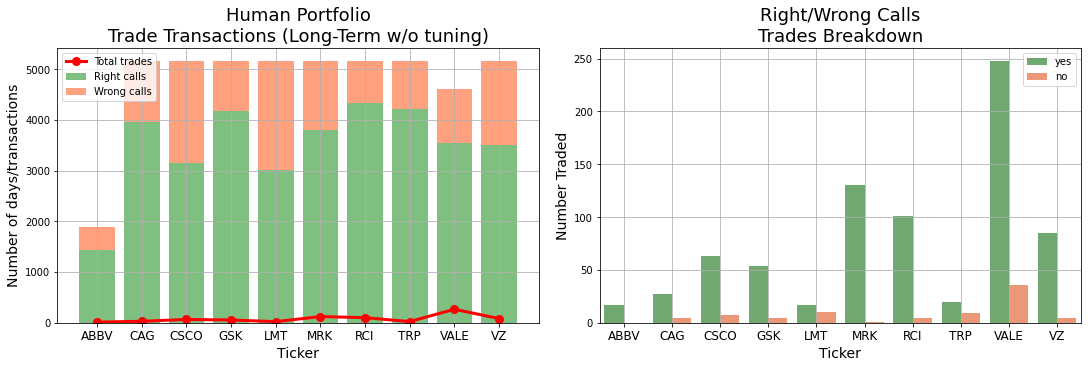

In [187]:
# plots trade transactions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white', constrained_layout=True)
lt_tmp = LT_DK_NT[['ticker', 'Total number of trade days', 'Number of right calls', 'Right calls %',
                   'Number of wrong calls', 'Wrong calls %', 'Total trades conducted']]

ax1.bar(lt_tmp['ticker'], lt_tmp['Number of right calls'], alpha=0.5, color='green', zorder=1, label='Right calls')
ax1.bar(lt_tmp['ticker'], lt_tmp['Number of wrong calls'], alpha=0.5, color='orangered', zorder=1,
        bottom=lt_tmp['Number of right calls'], label='Wrong calls')

ax1.plot(lt_tmp['ticker'], lt_tmp['Total trades conducted'], lw=3, marker='o', markersize=8, color='red',
         label='Total trades', zorder=2);
ax1.set_title('Human Portfolio\nTrade Transactions (Long-Term w/o tuning)', fontsize=18)
ax1.set_xlabel('Ticker', fontsize=14)
ax1.set_xticklabels(lt_tmp.ticker, fontsize=12)
ax1.set_ylabel('Number of days/transactions', fontsize=14)
ax1.legend()
ax1.grid(zorder=0)

# plot right/wrong trades breakdown
lt_tmp_breakdown = LT_TRANS_DK_NT[LT_TRANS_DK_NT['total_plus_comm_fees']!=0]
sns.barplot(x='ticker', y='total_plus_comm_fees', data=lt_tmp_breakdown, hue='right_call?',
            hue_order=['yes', 'no'], palette=['green', 'orangered'], alpha=0.6, dodge=True, orient='v',
            estimator=len, ax=ax2)
ax2.set_title('Right/Wrong Calls\nTrades Breakdown', fontsize=18)
ax2.set_xlabel('Ticker', fontsize=14)
ax2.set_xticklabels(lt_tmp.ticker, fontsize=12)
ax2.set_ylabel('Number Traded', fontsize=14)
ax2.legend()
ax2.grid(zorder=0)

plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'LT_20yrs_port_trans_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** Despite having an overwhelming number of "right calls", there were not many trades conducted. This is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

Fortunately, the number of "right call" for each company was higher than the number of "wrong calls".

In [188]:
lt_tmp

,ticker,Total number of trade days,Number of right calls,Right calls %,Number of wrong calls,Wrong calls %,Total trades conducted
0,ABBV,1897,1436,75.698471,461,24.301529,14
1,CAG,5166,3968,76.809911,1198,23.190089,30
2,CSCO,5166,3159,61.149826,2007,38.850174,66
3,GSK,5167,4172,80.711937,997,19.288063,55
4,LMT,5167,3005,58.135036,2164,41.864964,23
5,MRK,5166,3794,73.441734,1372,26.558266,123
6,RCI,5166,4329,83.797909,837,16.202091,101
7,TRP,5166,4216,81.610530,950,18.389470,24
8,VALE,4612,3547,76.908066,1065,23.091934,267
9,VZ,5166,3501,67.770035,1665,32.229965,83


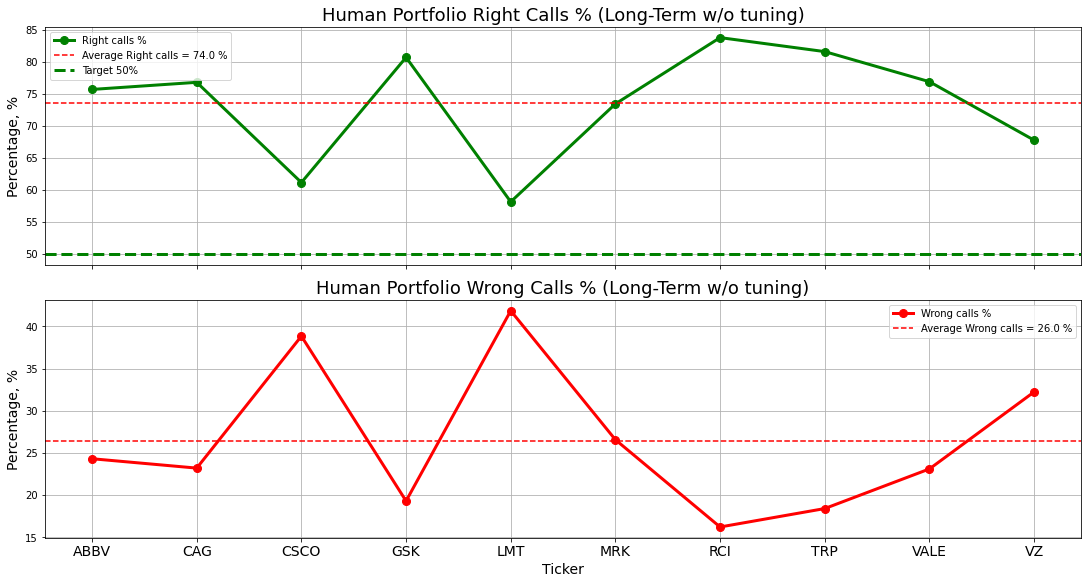

In [189]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)

ax1.plot(lt_tmp['ticker'], lt_tmp['Right calls %'], lw=3, marker='o',
         markersize=8, color='g', zorder=2, label='Right calls %')

ax1.set_title('Human Portfolio Right Calls % (Long-Term w/o tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)

label='Average Right calls = '+str(round(lt_tmp['Right calls %'].mean()))+' %'
ax1.axhline(y=lt_tmp['Right calls %'].mean(), color='r', ls='--', label=label)
ax1.axhline(y=50, color='green', ls='--', lw=3, label='Target 50%')
            
ax1.grid()
ax1.legend()

ax2.plot(lt_tmp['ticker'], lt_tmp['Wrong calls %'], lw=3, marker='o',
         markersize=8, color='red', zorder=2, label='Wrong calls %')
ax2.set_title('Human Portfolio Wrong Calls % (Long-Term w/o tuning)', fontsize=18)
ax2.set_ylabel('Percentage, %', fontsize=14)

label='Average Wrong calls = '+str(round(lt_tmp['Wrong calls %'].mean()))+' %'
ax2.axhline(y=lt_tmp['Wrong calls %'].mean(), color='r', ls='--', label=label)

ax2.grid()
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'LT_20yrs_port_calls_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** It is good to see that the Human portfolio had a very high "right calls" mean percentage and all the companies had their "right calls" percentage to be above 50%. This is evident that despite no tuning was done, the LSTM model is learning efficiently.

In [190]:
# print result and add to df
print('===== Human Portfolio without tuning (20 yrs) =====')
print('Average percentage of right calls =', round(lt_tmp['Right calls %'].mean()), '%')
print('Average percentage of wrong calls =', round(lt_tmp['Wrong calls %'].mean()), '%')

===== Human Portfolio without tuning (20 yrs) =====
Average percentage of right calls = 74.0 %
Average percentage of wrong calls = 26.0 %


## How much did we make or loss?

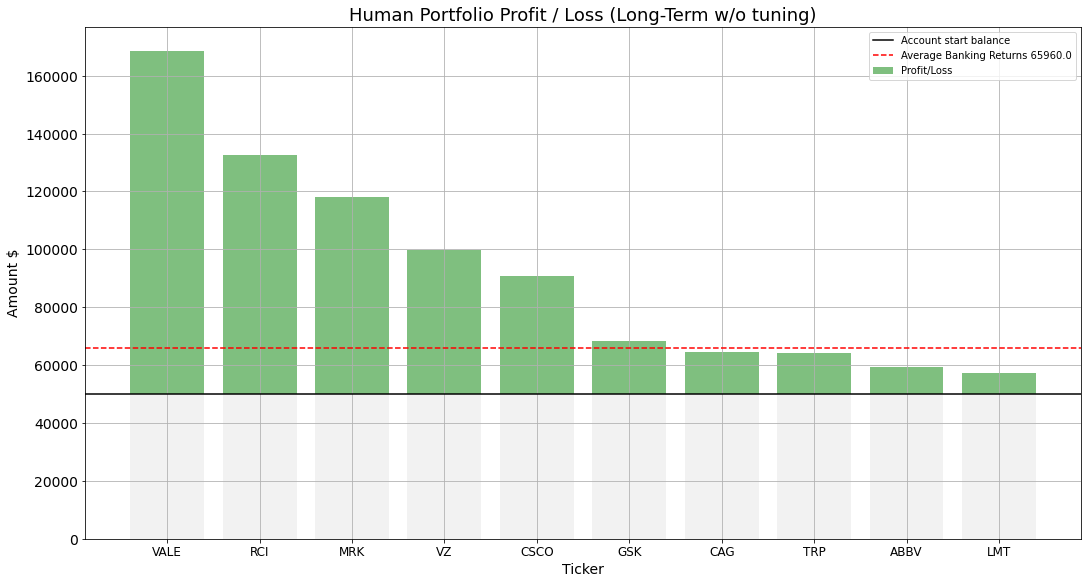

In [191]:
# plots profit and loss
plt.figure(figsize=(15,8), facecolor='white', constrained_layout=True)
lt_tmp2 = LT_DK_NT[['ticker', 'Account starting balance', 'Account ending balance',
                    'Profit/Loss', 'Banking returns']].sort_values('Profit/Loss', ascending=False)

plt.bar(lt_tmp2['ticker'], lt_tmp2['Account starting balance'], alpha=0.1, color='grey', label='',
       zorder=1)
plt.bar(lt_tmp2['ticker'], lt_tmp2['Profit/Loss'], alpha=0.5, color='green', bottom=lt_tmp2['Account starting balance'],
        label='Profit/Loss', zorder=1)
plt.axhline(y=50000, color='k', label='Account start balance')

plt.axhline(y=lt_tmp2['Banking returns'].mean(), color='r', ls='--',
            label='Average Banking Returns '+str(round(lt_tmp2['Banking returns'].mean())))

plt.legend()
plt.title('Human Portfolio Profit / Loss (Long-Term w/o tuning)', fontsize=18)
plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Amount $', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0)
plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'LT_20yrs_port_pnl_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** If we were to leave the 500K investment funds in the bank @ 1.5% interest per yr, it would compound to about 66K over 20 yrs (red line). However, if following our model predictions and trading strategy, 6 out of the 10 companies would have made a higher return than leaving it in the bank. Hopefully, with model tuning those companies (CAG, TRP, ABBV, LMT) who under perform can do better.

In [192]:
lt_tmp2

,ticker,Account starting balance,Account ending balance,Profit/Loss,Banking returns
8,VALE,50000.0,168481.258095,118481.258095,65367.03
6,RCI,50000.0,132648.048336,82648.048336,67342.75
5,MRK,50000.0,118131.621322,68131.621322,67342.75
9,VZ,50000.0,99943.489096,49943.489096,67342.75
2,CSCO,50000.0,90949.767056,40949.767056,67342.75
3,GSK,50000.0,68206.596439,18206.596439,67342.75
1,CAG,50000.0,64581.541747,14581.541747,67342.75
7,TRP,50000.0,64253.240450,14253.240450,67342.75
0,ABBV,50000.0,59282.980303,9282.980303,55492.25
4,LMT,50000.0,57340.623370,7340.623370,67342.75


In [193]:
# sum up total portfolio profit/loss
print('===== Human Portfolio without tuning (20yrs) =====')
tot_pnl = lt_tmp2['Profit/Loss'].sum()
print(f'Portfolio total profit/loss      = $ {round(tot_pnl)}')
bank_amt = lt_tmp2['Account starting balance'].sum()
tot_bank = lt_tmp2['Banking returns'].sum() - (lt_tmp2['Account starting balance'].mean()*len(lt_tmp2.index))
print(f'Banking $ {round(bank_amt)} @ 1.5% per yr = $ {round(tot_bank)}')
print(f'Invest vs Banking over 20 yrs    = $ {round(tot_pnl - tot_bank)}')

===== Human Portfolio without tuning (20yrs) =====
Portfolio total profit/loss      = $ 423819.0
Banking $ 500000.0 @ 1.5% per yr = $ 159601.0
Invest vs Banking over 20 yrs    = $ 264218.0


In [194]:
# adding result to df for comparison later
add_list = [round(lt_tmp['Right calls %'].mean()),
            round(lt_tmp['Wrong calls %'].mean()),
            round(tot_pnl), round(LT_DK_NT['Total Percentage return (whole period)'].mean(),2),
            round(tot_bank), round(tot_pnl - tot_bank),
            round(LT_DK_NT['Percentage return per yr'].mean(),2)]
add_df = pd.DataFrame(add_list, columns=['Human Portfolio w/o tuning (20 yrs)'])
port_summary_df = pd.concat([blank_df, add_df], axis=1)
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs)
0,Avg right calls %,74.00
1,Avg wrong calls %,26.00
2,Total profit/loss $,423819.00
3,Total Percentage return (whole period),84.76
4,Banking @ 1.5%/yr $,159601.00
5,Invest vs Banking $,264218.00
6,Percentage return per yr,4.54


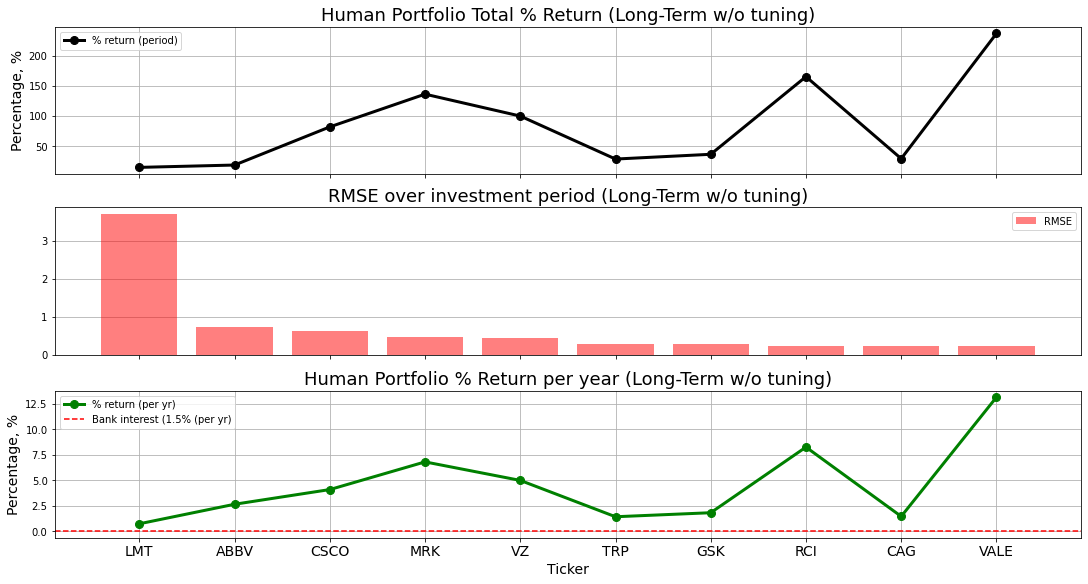

In [195]:
# plots percentages
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)
lt_tmp3 = LT_DK_NT[['ticker', 'Total Percentage return (whole period)', 'Percentage return per yr',
                    'RMSE']].sort_values('RMSE', ascending=False)

ax1.plot(lt_tmp3['ticker'], lt_tmp3['Total Percentage return (whole period)'], lw=3, marker='o',
         markersize=8, color='k', zorder=2, label='% return (period)')

ax1.set_title('Human Portfolio Total % Return (Long-Term w/o tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)
ax1.grid()
ax1.legend()

ax2.bar(lt_tmp3['ticker'], lt_tmp3['RMSE'], lw=3, color='r', alpha=0.5, zorder=2, label='RMSE')
ax2.set_title('RMSE over investment period (Long-Term w/o tuning)', fontsize=18)
ax2.grid(axis='y')
ax2.legend()

ax3.plot(lt_tmp3['ticker'], lt_tmp3['Percentage return per yr'], lw=3, marker='o',
         markersize=8, color='green', zorder=2, label='% return (per yr)')

ax3.set_title('Human Portfolio % Return per year (Long-Term w/o tuning)', fontsize=18)
ax3.set_ylabel('Percentage, %', fontsize=14)
ax3.axhline(y=0.015, color='r', ls='--', label='Bank interest (1.5% (per yr)')
ax3.grid()
ax3.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'LT_20yrs_port_rtn_rmse_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** As mentioned, a low RMSE does not always mean the model is good in our context. However, in the baseline un-tune model, we did observe that the company (LMT) with the highest RMSE had the lowest return % and the company (VALE) with the lowest RMSE had the highest return %. The companies in between have varying performance. This is exactly the reason why an investment portfolio have to consist of multiple companies to diversify the risk and to achieve collective returns.

In [196]:
lt_tmp3

,ticker,Total Percentage return (whole period),Percentage return per yr,RMSE
4,LMT,14.681247,0.734062,3.688425
0,ABBV,18.565961,2.652280,0.740808
2,CSCO,81.899534,4.094977,0.613056
5,MRK,136.263243,6.813162,0.468083
9,VZ,99.886978,4.994349,0.436720
7,TRP,28.506481,1.425324,0.287116
3,GSK,36.413193,1.820660,0.286729
6,RCI,165.296097,8.264805,0.226851
1,CAG,29.163083,1.458154,0.225994
8,VALE,236.962516,13.164584,0.216699


# SHORT TERM HUMAN PORTFOLIO (without tuning)

In [197]:
# filtering
ST_DK_NT = strat_1yr_not_tuned[strat_1yr_not_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)
ST_TRANS_DK_NT = trans_1yr_not_tuned[trans_1yr_not_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)

## How often did we get it right?

<ipython-input-198-8a3f8af8f3cf>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(st_tmp.ticker, fontsize=12)


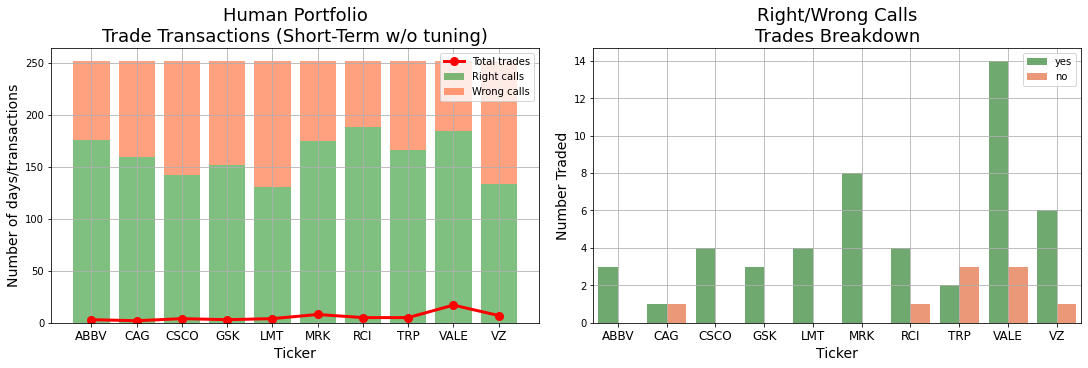

In [198]:
# plots trade transactions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white', constrained_layout=True)
st_tmp = ST_DK_NT[['ticker', 'Total number of trade days', 'Number of right calls', 'Right calls %',
                   'Number of wrong calls', 'Wrong calls %', 'Total trades conducted']]

ax1.bar(st_tmp['ticker'], st_tmp['Number of right calls'], alpha=0.5, color='green', zorder=1, label='Right calls')
ax1.bar(st_tmp['ticker'], st_tmp['Number of wrong calls'], alpha=0.5, color='orangered', zorder=1,
        bottom=st_tmp['Number of right calls'], label='Wrong calls')

ax1.plot(st_tmp['ticker'], st_tmp['Total trades conducted'], lw=3, marker='o', markersize=8, color='red',
         label='Total trades', zorder=2)
ax1.set_title('Human Portfolio\nTrade Transactions (Short-Term w/o tuning)', fontsize=18)
ax1.set_xlabel('Ticker', fontsize=14)
ax1.set_xticklabels(st_tmp.ticker, fontsize=12)
ax1.set_ylabel('Number of days/transactions', fontsize=14)
ax1.grid(zorder=0)
ax1.legend()

# plot right/wrong trades breakdown
st_tmp_breakdown = ST_TRANS_DK_NT[ST_TRANS_DK_NT['total_plus_comm_fees']!=0]
sns.barplot(x='ticker', y='total_plus_comm_fees', data=st_tmp_breakdown, hue='right_call?',
            hue_order=['yes', 'no'], palette=['green', 'orangered'], alpha=0.6, dodge=True, orient='v',
            estimator=len, ax=ax2)
ax2.set_title('Right/Wrong Calls\nTrades Breakdown', fontsize=18)
ax2.set_xlabel('Ticker', fontsize=14)
ax2.set_xticklabels(st_tmp.ticker, fontsize=12)
ax2.set_ylabel('Number Traded', fontsize=14)
ax2.legend()
ax2.grid(zorder=0)

plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'ST_1yr_port_trans_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** Similar to the long term portfolio, despite having an overwhelming number of "right calls" there were not many trades conducted. This is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

Fortunately, the number of "right call" for most companies was higher than the number of "wrong calls". The only exception was TRP.

In [199]:
st_tmp

,ticker,Total number of trade days,Number of right calls,Right calls %,Number of wrong calls,Wrong calls %,Total trades conducted
0,ABBV,252,176,69.841270,76,30.158730,3
1,CAG,252,159,63.095238,93,36.904762,2
2,CSCO,252,142,56.349206,110,43.650794,4
3,GSK,252,152,60.317460,100,39.682540,3
4,LMT,252,131,51.984127,121,48.015873,4
5,MRK,252,175,69.444444,77,30.555556,8
6,RCI,252,188,74.603175,64,25.396825,5
7,TRP,252,166,65.873016,86,34.126984,5
8,VALE,252,184,73.015873,68,26.984127,17
9,VZ,252,133,52.777778,119,47.222222,7


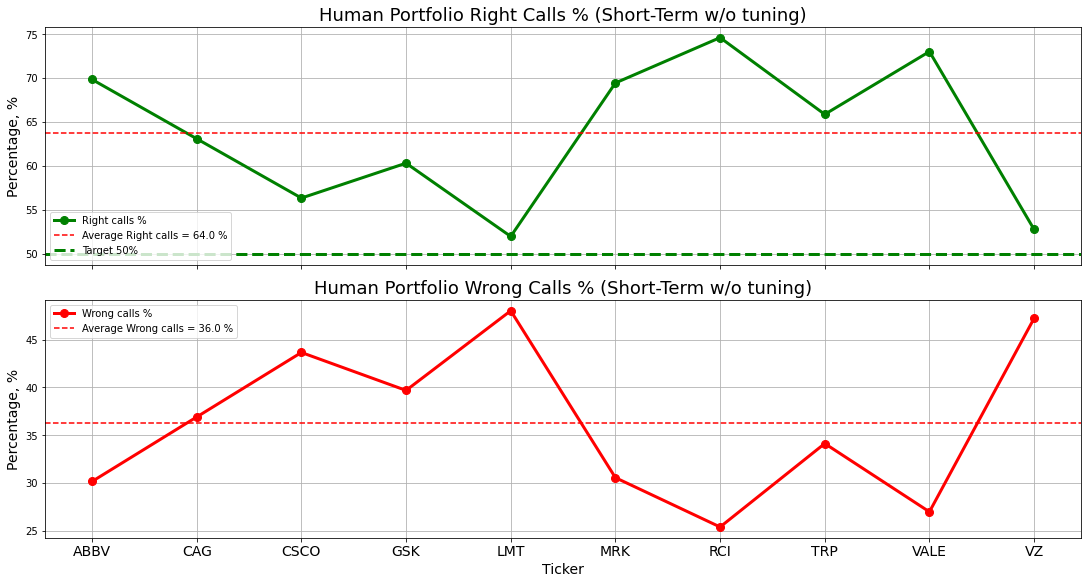

In [200]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)

ax1.plot(st_tmp['ticker'], st_tmp['Right calls %'], lw=3, marker='o',
         markersize=8, color='g', zorder=2, label='Right calls %')

ax1.set_title('Human Portfolio Right Calls % (Short-Term w/o tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)

label='Average Right calls = '+str(round(st_tmp['Right calls %'].mean()))+' %'
ax1.axhline(y=st_tmp['Right calls %'].mean(), color='r', ls='--', label=label)
ax1.axhline(y=50, color='green', ls='--', lw=3, label='Target 50%')

ax1.grid()
ax1.legend()

ax2.plot(st_tmp['ticker'], st_tmp['Wrong calls %'], lw=3, marker='o',
         markersize=8, color='red', zorder=2, label='Wrong calls %')

ax2.set_title('Human Portfolio Wrong Calls % (Short-Term w/o tuning)', fontsize=18)
ax2.set_ylabel('Percentage, %', fontsize=14)

label='Average Wrong calls = '+str(round(st_tmp['Wrong calls %'].mean()))+' %'
ax2.axhline(y=st_tmp['Wrong calls %'].mean(), color='r', ls='--', label=label)

ax2.grid()
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'ST_1yr_port_calls_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** It is good to see that the Human portfolio continued to have a high "right calls" mean percentage and all the companies had their "right calls" percentage to be above 50%. This is evident that despite no tuning was done, the LSTM model is learning efficiently.

In [201]:
print('===== Human Portfolio without tuning (1yr) =====')
print('Average percentage of right calls =', round(st_tmp['Right calls %'].mean()), '%')
print('Average percentage of wrong calls =', round(st_tmp['Wrong calls %'].mean()), '%')

===== Human Portfolio without tuning (1yr) =====
Average percentage of right calls = 64.0 %
Average percentage of wrong calls = 36.0 %


## How much did we make or loss?

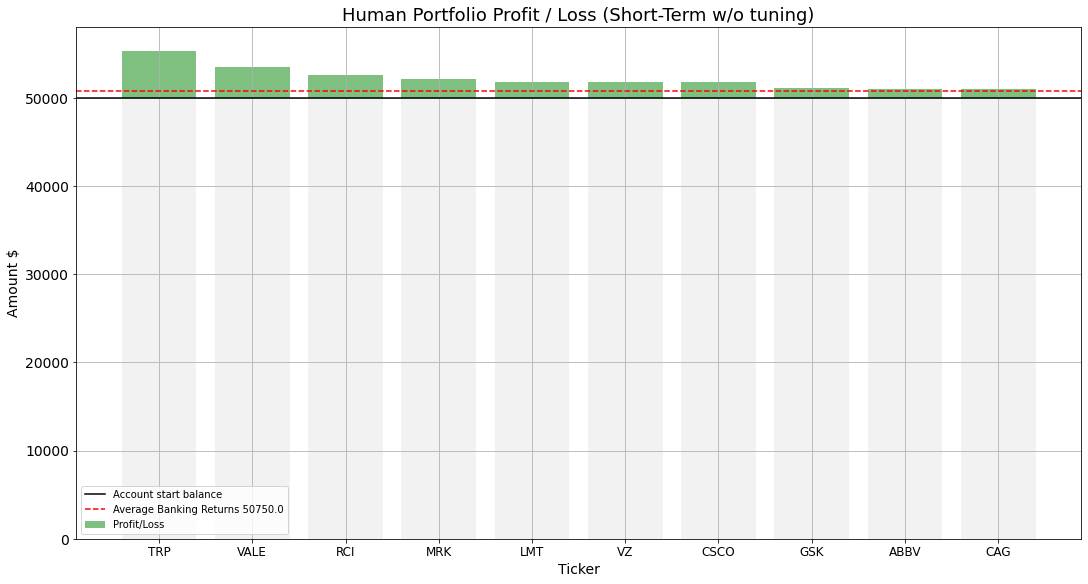

In [202]:
# plots profit and loss
plt.figure(figsize=(15,8), facecolor='white', constrained_layout=True)
st_tmp2 = ST_DK_NT[['ticker', 'Account starting balance', 'Account ending balance',
                    'Profit/Loss', 'Banking returns']].sort_values('Profit/Loss', ascending=False)

plt.bar(st_tmp2['ticker'], st_tmp2['Account starting balance'], alpha=0.1, color='grey', label='',
        zorder=1)
plt.bar(st_tmp2['ticker'], st_tmp2['Profit/Loss'], alpha=0.5, color='green', bottom=st_tmp2['Account starting balance'],
        label='Profit/Loss', zorder=1)
plt.axhline(y=50000, color='k', label='Account start balance')

plt.axhline(y=st_tmp2['Banking returns'].mean(), color='r', ls='--',
            label='Average Banking Returns '+str(round(st_tmp2['Banking returns'].mean())))

plt.legend(loc='lower left')
plt.title('Human Portfolio Profit / Loss (Short-Term w/o tuning)', fontsize=18)
plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Amount $', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0)
plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'ST_1yr_port_pnl_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** If we were to leave the 500K investment funds in the bank @ 1.5% interest per yr, it would compound to about 50,750 in a yr (red line). However, if following our model predictions and trading strategy, all 10 companies would have made a higher return than leaving it in the bank. Hopefully, with model tuning the returns can be even higher.

In [203]:
st_tmp2

,ticker,Account starting balance,Account ending balance,Profit/Loss,Banking returns
7,TRP,50000.0,55273.369080,5273.369080,50750.0
8,VALE,50000.0,53457.961386,3457.961386,50750.0
6,RCI,50000.0,52624.379915,2624.379915,50750.0
5,MRK,50000.0,52150.220588,2150.220588,50750.0
4,LMT,50000.0,51771.257346,1771.257346,50750.0
9,VZ,50000.0,51763.024391,1763.024391,50750.0
2,CSCO,50000.0,51755.629199,1755.629199,50750.0
3,GSK,50000.0,51063.890397,1063.890397,50750.0
0,ABBV,50000.0,51010.394445,1010.394445,50750.0
1,CAG,50000.0,50940.245635,940.245635,50750.0


In [204]:
# sum up total portfolio profit/loss
print('===== Human Portfolio without tuning (1yrs) =====')
tot_pnl = st_tmp2['Profit/Loss'].sum()
print(f'Portfolio total profit/loss      = $ {round(tot_pnl)}')
bank_amt = st_tmp2['Account starting balance'].sum()
tot_bank = st_tmp2['Banking returns'].sum() - (st_tmp2['Account starting balance'].mean()*len(st_tmp2.index))
print(f'Banking $ {round(bank_amt)} @ 1.5% per yr = $ {round(tot_bank)}')
print(f'Invest vs Banking over 1 yr      = $ {round(tot_pnl - tot_bank)}')

===== Human Portfolio without tuning (1yrs) =====
Portfolio total profit/loss      = $ 21810.0
Banking $ 500000.0 @ 1.5% per yr = $ 7500.0
Invest vs Banking over 1 yr      = $ 14310.0


In [205]:
# adding result to df for comparison later
add_list = [round(st_tmp['Right calls %'].mean()),
            round(st_tmp['Wrong calls %'].mean()),
            round(tot_pnl), round(ST_DK_NT['Total Percentage return (whole period)'].mean(),2),
            round(tot_bank), round(tot_pnl - tot_bank),
            round(ST_DK_NT['Percentage return per yr'].mean(),2)]
add_df = pd.DataFrame(add_list, columns=['Human Portfolio w/o tuning (1 yr)'])
port_summary_df = pd.concat([port_summary_df, add_df], axis=1)
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr)
0,Avg right calls %,74.00,64.00
1,Avg wrong calls %,26.00,36.00
2,Total profit/loss $,423819.00,21810.00
3,Total Percentage return (whole period),84.76,4.36
4,Banking @ 1.5%/yr $,159601.00,7500.00
5,Invest vs Banking $,264218.00,14310.00
6,Percentage return per yr,4.54,4.36


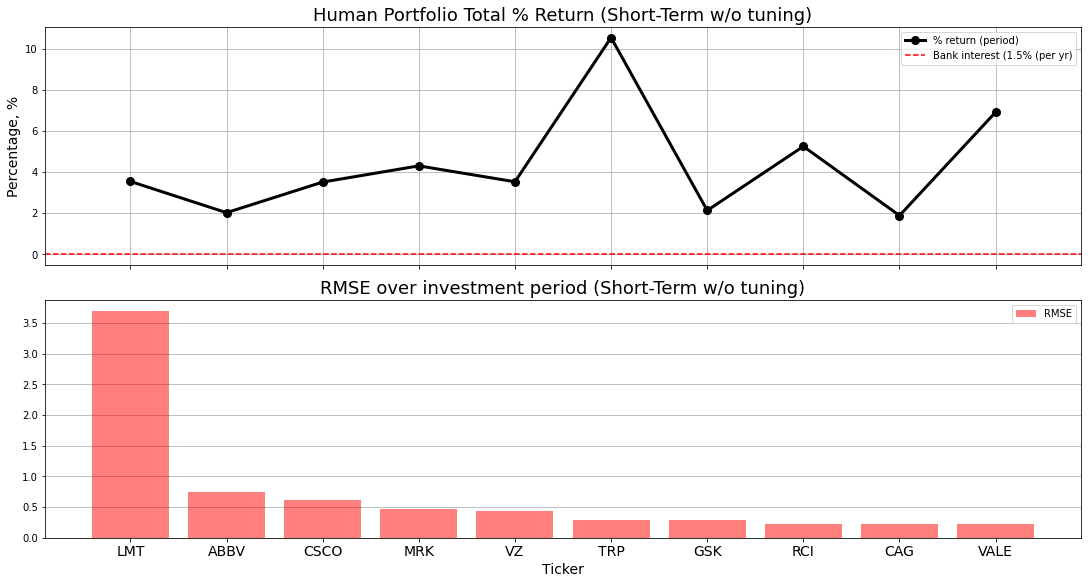

In [206]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)
st_tmp3 = ST_DK_NT[['ticker', 'Total Percentage return (whole period)', 'Percentage return per yr',
                    'RMSE']].sort_values('RMSE', ascending=False)

ax1.plot(st_tmp3['ticker'], st_tmp3['Total Percentage return (whole period)'], lw=3, marker='o',
         markersize=8, color='k', zorder=2, label='% return (period)')

ax1.set_title('Human Portfolio Total % Return (Short-Term w/o tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)
ax1.axhline(y=0.015, color='r', ls='--', label='Bank interest (1.5% (per yr)')
ax1.grid()
ax1.legend()

ax2.bar(st_tmp3['ticker'], st_tmp3['RMSE'], lw=3, color='r', alpha=0.5, zorder=2, label='RMSE')
ax2.set_title('RMSE over investment period (Short-Term w/o tuning)', fontsize=18)
ax2.grid(axis='y')
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITHOUT_TUNING+'ST_1yr_port_rtn_rmse_no_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** In the short term horizon, the company (LMT) with the highest RMSE continued to have one of the lowest return % and the company (VALE) with the lowest RMSE had the second highest return %. The companies in between have varying performance. Thus, even in a short term horizon, it is evident that an investment portfolio have to consist of multiple companies to diversify the risk and to achieve collective returns.

In [207]:
st_tmp3

,ticker,Total Percentage return (whole period),Percentage return per yr,RMSE
4,LMT,3.542515,3.542515,3.688425
0,ABBV,2.020789,2.020789,0.740808
2,CSCO,3.511258,3.511258,0.613056
5,MRK,4.300441,4.300441,0.468083
9,VZ,3.526049,3.526049,0.436720
7,TRP,10.546738,10.546738,0.287116
3,GSK,2.127781,2.127781,0.286729
6,RCI,5.248760,5.248760,0.226851
1,CAG,1.880491,1.880491,0.225994
8,VALE,6.915923,6.915923,0.216699


# LONG TERM HUMAN PORTFOLIO (with tuning)

In [208]:
# call the helper function 
strat_20yr_tuned, strat_1yr_tuned = perf_data_import(PERF_DIR_WITH_TUNING)
trans_20yr_tuned, trans_1yr_tuned = trans_data_import(TRANS_DIR_WITH_TUNING)

In [209]:
# filtering 
LT_DK_T = strat_20yr_tuned[strat_20yr_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)
LT_TRANS_DK_T = trans_20yr_tuned[trans_20yr_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)

## How often did we get it right?

<ipython-input-210-0e24126d51b8>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tuned_lt_tmp.ticker, fontsize=12)


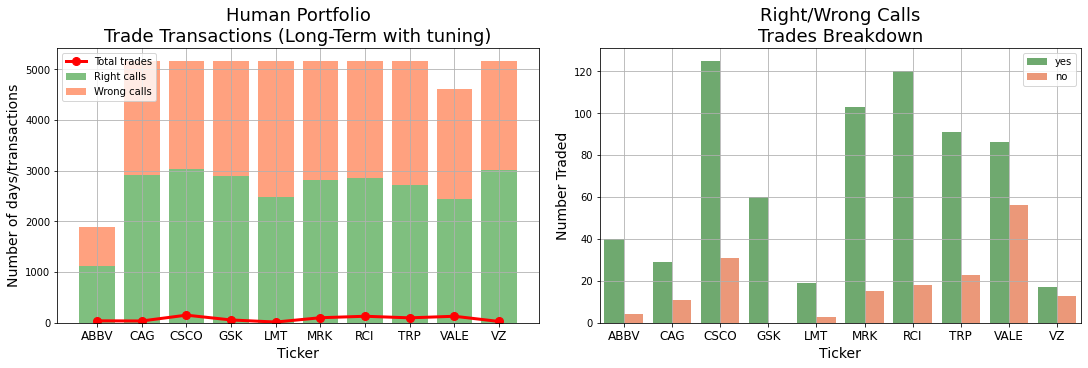

In [210]:
# plots trade transactions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white', constrained_layout=True)
tuned_lt_tmp = LT_DK_T[['ticker', 'Total number of trade days', 'Number of right calls', 'Right calls %',
                        'Number of wrong calls', 'Wrong calls %', 'Total trades conducted']]

ax1.bar(tuned_lt_tmp['ticker'], tuned_lt_tmp['Number of right calls'], alpha=0.5, color='green', zorder=1,
        label='Right calls')
ax1.bar(tuned_lt_tmp['ticker'], tuned_lt_tmp['Number of wrong calls'], alpha=0.5, color='orangered', zorder=1,
        label='Wrong calls', bottom=tuned_lt_tmp['Number of right calls'])

ax1.plot(tuned_lt_tmp['ticker'], tuned_lt_tmp['Total trades conducted'], lw=3, marker='o', markersize=8,
         label='Total trades', color='red', zorder=2);

ax1.set_title('Human Portfolio\nTrade Transactions (Long-Term with tuning)', fontsize=18)
ax1.set_xlabel('Ticker', fontsize=14)
ax1.set_xticklabels(tuned_lt_tmp.ticker, fontsize=12)
ax1.set_ylabel('Number of days/transactions', fontsize=14)
ax1.legend()
ax1.grid(zorder=0)

# plot right/wrong trades breakdown
tuned_lt_tmp_breakdown = LT_TRANS_DK_T[LT_TRANS_DK_T['total_plus_comm_fees']!=0]
sns.barplot(x='ticker', y='total_plus_comm_fees', data=tuned_lt_tmp_breakdown, hue='right_call?',
            hue_order=['yes', 'no'], palette=['green', 'orangered'], alpha=0.6, dodge=True, orient='v',
            estimator=len, ax=ax2)
ax2.set_title('Right/Wrong Calls\nTrades Breakdown', fontsize=18)
ax2.set_xlabel('Ticker', fontsize=14)
ax2.set_xticklabels(tuned_lt_tmp.ticker, fontsize=12)
ax2.set_ylabel('Number Traded', fontsize=14)
ax2.legend()
ax2.grid(zorder=0)

plt.savefig(IMAGE_DIR_WITH_TUNING+'LT_20yrs_port_trans_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** We observed that even with model tuning, despite having an overwhelming number of "right calls", the number of trades continued to be very low. This is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

To increase the number of trades does not guarantee better returns, it only increases the number of times we are taking a chance with our model predictions. Therefore, as long as the tuned model is having better returns than the un-tune model. We do not recommend adjusting the trading strategy rules.

Fortunately, the number of "right calls" for each company was higher than the number of "wrong calls".

In [211]:
tuned_lt_tmp

,ticker,Total number of trade days,Number of right calls,Right calls %,Number of wrong calls,Wrong calls %,Total trades conducted
0,ABBV,1897,1117,58.882446,780,41.117554,39
1,CAG,5166,2910,56.329849,2256,43.670151,36
2,CSCO,5166,3036,58.768873,2130,41.231127,151
3,GSK,5167,2892,55.948926,2277,44.051074,56
4,LMT,5167,2475,47.881602,2694,52.118398,15
5,MRK,5166,2810,54.394115,2356,45.605885,100
6,RCI,5166,2863,55.420054,2303,44.579946,129
7,TRP,5166,2715,52.555168,2451,47.444832,98
8,VALE,4612,2447,53.057242,2165,46.942758,129
9,VZ,5166,3022,58.497871,2144,41.502129,26


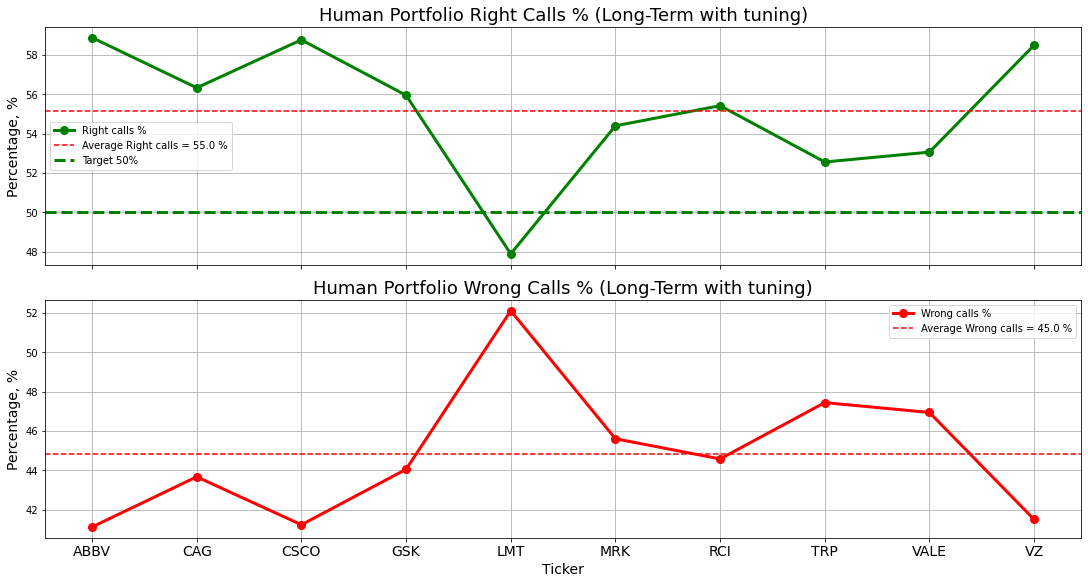

In [212]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)

ax1.plot(tuned_lt_tmp['ticker'], tuned_lt_tmp['Right calls %'], lw=3, marker='o',
         markersize=8, color='g', zorder=2, label='Right calls %')

ax1.set_title('Human Portfolio Right Calls % (Long-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)

label='Average Right calls = '+str(round(tuned_lt_tmp['Right calls %'].mean()))+' %'
ax1.axhline(y=tuned_lt_tmp['Right calls %'].mean(), color='r', ls='--', label=label)
ax1.axhline(y=50, color='green', ls='--', lw=3, label='Target 50%')
            
ax1.grid()
ax1.legend()

ax2.plot(tuned_lt_tmp['ticker'], tuned_lt_tmp['Wrong calls %'], lw=3, marker='o',
         markersize=8, color='red', zorder=2, label='Wrong calls %')

ax2.set_title('Human Portfolio Wrong Calls % (Long-Term with tuning)', fontsize=18)
ax2.set_ylabel('Percentage, %', fontsize=14)

label='Average Wrong calls = '+str(round(tuned_lt_tmp['Wrong calls %'].mean()))+' %'
ax2.axhline(y=tuned_lt_tmp['Wrong calls %'].mean(), color='r', ls='--', label=label)

ax2.grid()
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'LT_20yrs_port_calls_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With model tuning, we were surprised to see that the "right calls" mean percentage actually dropped lower than the un-tune model. One company (LMT) even dropped below 50%. However, the portfolio's "right calls" mean percentage is still above 50% so it is still acceptable and proved that the LSTM model is learning efficiently.

We suspect that the drop in percentage is due to the Keras RandomSearch nature of random permutations as compared to the un-tune baseline model where its LSTM layers and hyperparameters are fixed throughout. Given the randomness, it is possible that some companies tuned model may not have learn the most efficient patterns of the features.

As it is not computationally possible for us to search every permutation, this was inevitable. This was the reason for implementing an additional layer of risk management through the trading strategy rules.

A quick look at LMT predictions plot does show that the model was not tuned sufficiently towards the end of the data period.

![LMTpred_vs_actual_all_seq](images/with_keras_tuning/LMTpred_vs_actual_all_seq.png "LMTpred_vs_actual_all_seq")

In [213]:
print('===== Human Portfolio with tuning (20yrs) =====')
print('Average percentage of right calls =', round(tuned_lt_tmp['Right calls %'].mean()), '%')
print('Average percentage of wrong calls =', round(tuned_lt_tmp['Wrong calls %'].mean()), '%')

===== Human Portfolio with tuning (20yrs) =====
Average percentage of right calls = 55.0 %
Average percentage of wrong calls = 45.0 %


## How much did we make or loss?

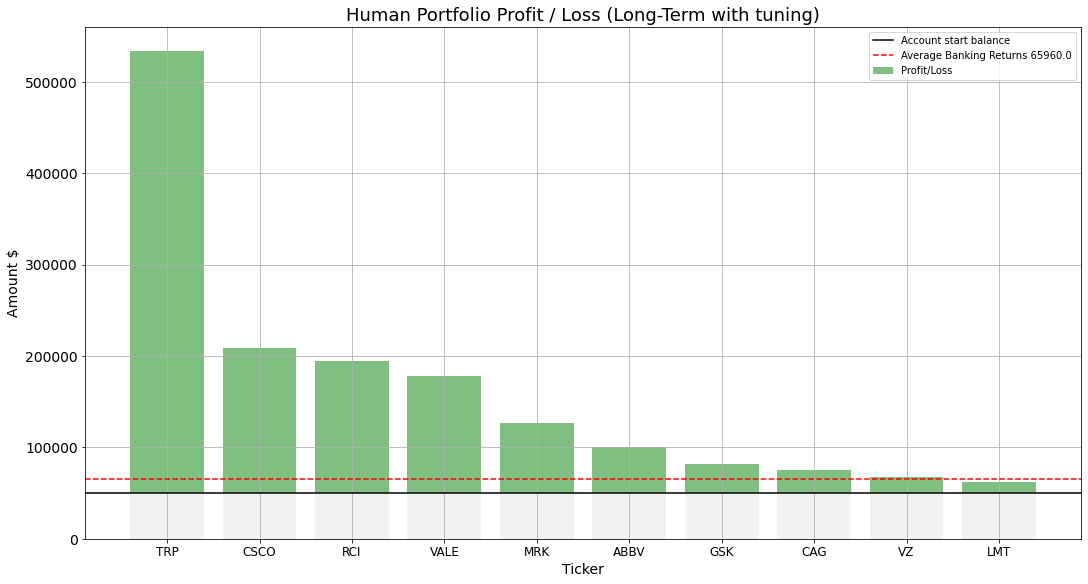

In [214]:
# plots profit and loss
plt.figure(figsize=(15,8), facecolor='white', constrained_layout=True)
tuned_lt_tmp2 = LT_DK_T[['ticker', 'Account starting balance', 'Account ending balance',
                         'Profit/Loss', 'Banking returns']].sort_values('Profit/Loss', ascending=False)

plt.bar(tuned_lt_tmp2['ticker'], tuned_lt_tmp2['Account starting balance'], alpha=0.1, color='grey', label='',
       zorder=1)
plt.bar(tuned_lt_tmp2['ticker'], tuned_lt_tmp2['Profit/Loss'], alpha=0.5, color='green',
        bottom=tuned_lt_tmp2['Account starting balance'], label='Profit/Loss', zorder=1)
plt.axhline(y=50000, color='k', label='Account start balance')

plt.axhline(y=tuned_lt_tmp2['Banking returns'].mean(), color='r', ls='--',
            label='Average Banking Returns '+str(round(tuned_lt_tmp2['Banking returns'].mean())))

plt.legend()
plt.title('Human Portfolio Profit / Loss (Long-Term with tuning)', fontsize=18)
plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Amount $', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0)
plt.savefig(IMAGE_DIR_WITH_TUNING+'LT_20yrs_port_pnl_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With model tuning, profits increased significantly across the board. In the un-tune model, there were four companies (CAG, TRP, ABBV, LMT) that had lower returns than leaving the 500K investment in the bank. Now with the tuned model, all four companies are having higher returns with only one (LMT) still making lesser returns than leaving in the bank. However, this was a significant improvement and proved that with model tuning, performance can be better.

In [215]:
tuned_lt_tmp2

,ticker,Account starting balance,Account ending balance,Profit/Loss,Banking returns
7,TRP,50000.0,495371.571930,483417.607086,67342.75
2,CSCO,50000.0,209200.700870,159200.700870,67342.75
6,RCI,50000.0,194330.605550,144330.605550,67342.75
8,VALE,50000.0,178275.838082,128275.838082,65367.03
5,MRK,50000.0,126554.081309,76554.081309,67342.75
0,ABBV,50000.0,100951.414922,50951.414922,55492.25
3,GSK,50000.0,81968.409364,31968.409364,67342.75
1,CAG,50000.0,75212.449819,25212.449819,67342.75
9,VZ,50000.0,67943.234187,17943.234187,67342.75
4,LMT,50000.0,62106.557454,12106.557454,67342.75


In [216]:
# sum up total portfolio profit/loss
print('===== Human Portfolio with tuning (20yrs) =====')
tot_pnl = tuned_lt_tmp2['Profit/Loss'].sum()
print(f'Portfolio total profit/loss      = $ {round(tot_pnl)}')
bank_amt = tuned_lt_tmp2['Account starting balance'].sum()
tot_bank = tuned_lt_tmp2['Banking returns'].sum() - (tuned_lt_tmp2['Account starting balance'].mean()*len(tuned_lt_tmp2.index))
print(f'Banking $ {round(bank_amt)} @ 1.5% per yr = $ {round(tot_bank)}')
print(f'Invest vs Banking over 20 yrs    = $ {round(tot_pnl - tot_bank)}')

===== Human Portfolio with tuning (20yrs) =====
Portfolio total profit/loss      = $ 1129961.0
Banking $ 500000.0 @ 1.5% per yr = $ 159601.0
Invest vs Banking over 20 yrs    = $ 970360.0


In [217]:
# adding result to df for comparison later
add_list = [round(tuned_lt_tmp['Right calls %'].mean()),
            round(tuned_lt_tmp['Wrong calls %'].mean()),
            round(tot_pnl), round(LT_DK_T['Total Percentage return (whole period)'].mean(),2),
            round(tot_bank), round(tot_pnl - tot_bank),
            round(LT_DK_T['Percentage return per yr'].mean(),2)]
add_df = pd.DataFrame(add_list, columns=['Human Portfolio w/ tuning (20 yrs)'])
port_summary_df = pd.concat([port_summary_df, add_df], axis=1)
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr),Human Portfolio w/ tuning (20 yrs)
0,Avg right calls %,74.00,64.00,55.00
1,Avg wrong calls %,26.00,36.00,45.00
2,Total profit/loss $,423819.00,21810.00,1129961.00
3,Total Percentage return (whole period),84.76,4.36,225.99
4,Banking @ 1.5%/yr $,159601.00,7500.00,159601.00
5,Invest vs Banking $,264218.00,14310.00,970360.00
6,Percentage return per yr,4.54,4.36,12.39


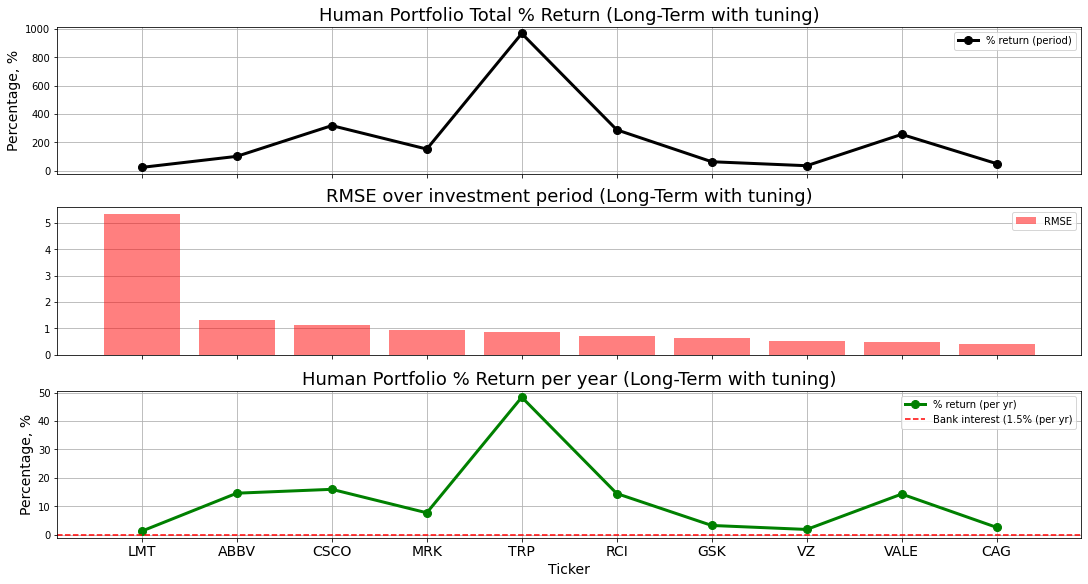

In [218]:
# plots percentages
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)
tuned_lt_tmp3 = LT_DK_T[['ticker', 'Total Percentage return (whole period)', 'Percentage return per yr',
                         'RMSE']].sort_values('RMSE', ascending=False)

ax1.plot(tuned_lt_tmp3['ticker'], tuned_lt_tmp3['Total Percentage return (whole period)'], lw=3, marker='o',
         markersize=8, color='k', zorder=2, label='% return (period)')

ax1.set_title('Human Portfolio Total % Return (Long-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)
ax1.grid()
ax1.legend()

ax2.bar(tuned_lt_tmp3['ticker'], tuned_lt_tmp3['RMSE'], lw=3, color='r', alpha=0.5, zorder=2, label='RMSE')
ax2.set_title('RMSE over investment period (Long-Term with tuning)', fontsize=18)
ax2.grid(axis='y')
ax2.legend()

ax3.plot(tuned_lt_tmp3['ticker'], tuned_lt_tmp3['Percentage return per yr'], lw=3, marker='o',
         markersize=8, color='green', zorder=2, label='% return (per yr)')

ax3.set_title('Human Portfolio % Return per year (Long-Term with tuning)', fontsize=18)
ax3.set_ylabel('Percentage, %', fontsize=14)
ax3.axhline(y=0.015, color='r', ls='--', label='Bank interest (1.5% (per yr)')
ax3.grid()
ax3.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'LT_20yrs_port_rtn_rmse_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With this set of tuned models, it is interesting to see that the company with the highest and lowest RMSE had the lowest returns percentage. Again, this re-iterated that an investment portfolio have to consist of multiple companies to diversify the risk and to achieve collective returns. More importantly, the tuned models continued to have a higher return percentage than leaving the money in the bank.

In [219]:
tuned_lt_tmp3

,ticker,Total Percentage return (whole period),Percentage return per yr,RMSE
4,LMT,24.213115,1.210656,5.326302
0,ABBV,101.902830,14.557547,1.330904
2,CSCO,318.401402,15.920070,1.108644
5,MRK,153.108163,7.655408,0.918737
7,TRP,966.835214,48.341761,0.860636
6,RCI,288.661211,14.433061,0.695337
3,GSK,63.936819,3.196841,0.623814
9,VZ,35.886468,1.794323,0.524897
8,VALE,256.551676,14.252871,0.484030
1,CAG,50.424900,2.521245,0.395584


# SHORT TERM HUMAN PORTFOLIO (with tuning)

In [220]:
# filtering
ST_DK_T = strat_1yr_tuned[strat_1yr_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)
ST_TRANS_DK_T = trans_1yr_tuned[trans_1yr_tuned.ticker.isin(domain_portfolio.ticker.unique())].reset_index(drop=True)

## How often did we get it right?

<ipython-input-221-72ca06242273>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tuned_st_tmp.ticker, fontsize=12)


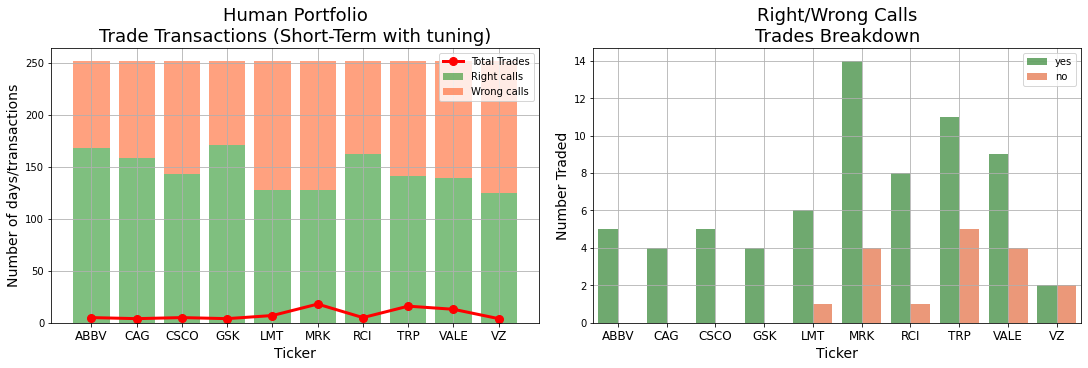

In [221]:
# plots trade transactions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white', constrained_layout=True)
tuned_st_tmp = ST_DK_T[['ticker', 'Total number of trade days', 'Number of right calls', 'Right calls %',
                        'Number of wrong calls', 'Wrong calls %', 'Total trades conducted']]

ax1.bar(tuned_st_tmp['ticker'], tuned_st_tmp['Number of right calls'], alpha=0.5, color='green',
        label= 'Right calls', zorder=1)
ax1.bar(tuned_st_tmp['ticker'], tuned_st_tmp['Number of wrong calls'], alpha=0.5, color='orangered', zorder=1,
        label='Wrong calls', bottom=tuned_st_tmp['Number of right calls'])

ax1.plot(tuned_st_tmp['ticker'], tuned_st_tmp['Total trades conducted'], lw=3, marker='o', markersize=8,
         label='Total Trades', color='red', zorder=2);

ax1.set_title('Human Portfolio\nTrade Transactions (Short-Term with tuning)', fontsize=18)
ax1.set_xlabel('Ticker', fontsize=14)
ax1.set_xticklabels(tuned_st_tmp.ticker, fontsize=12)
ax1.set_ylabel('Number of days/transactions', fontsize=14)
ax1.grid(zorder=0)
ax1.legend()

# plot right/wrong trades breakdown
tuned_st_tmp_breakdown = ST_TRANS_DK_T[ST_TRANS_DK_T['total_plus_comm_fees']!=0]
sns.barplot(x='ticker', y='total_plus_comm_fees', data=tuned_st_tmp_breakdown, hue='right_call?',
            hue_order=['yes', 'no'], palette=['green', 'orangered'], alpha=0.6, dodge=True, orient='v',
            estimator=len, ax=ax2)
ax2.set_title('Right/Wrong Calls\nTrades Breakdown', fontsize=18)
ax2.set_xlabel('Ticker', fontsize=14)
ax2.set_xticklabels(tuned_st_tmp.ticker, fontsize=12)
ax2.set_ylabel('Number Traded', fontsize=14)
ax2.legend()
ax2.grid(zorder=0)

plt.savefig(IMAGE_DIR_WITH_TUNING+'ST_1yr_port_trans_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** Similar to the long term portfolio, despite having high number of "right calls" there were not many trades conducted. This is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

Fortunately, the number of "right calls" for each company was higher than the number of "wrong calls".

In [222]:
tuned_st_tmp

,ticker,Total number of trade days,Number of right calls,Right calls %,Number of wrong calls,Wrong calls %,Total trades conducted
0,ABBV,252,168,66.666667,84,33.333333,5
1,CAG,252,158,62.698413,94,37.301587,4
2,CSCO,252,143,56.746032,109,43.253968,5
3,GSK,252,171,67.857143,81,32.142857,4
4,LMT,252,128,50.793651,124,49.206349,7
5,MRK,252,128,50.793651,124,49.206349,18
6,RCI,252,162,64.285714,90,35.714286,5
7,TRP,252,141,55.952381,111,44.047619,16
8,VALE,252,139,55.158730,113,44.841270,13
9,VZ,252,125,49.603175,127,50.396825,4


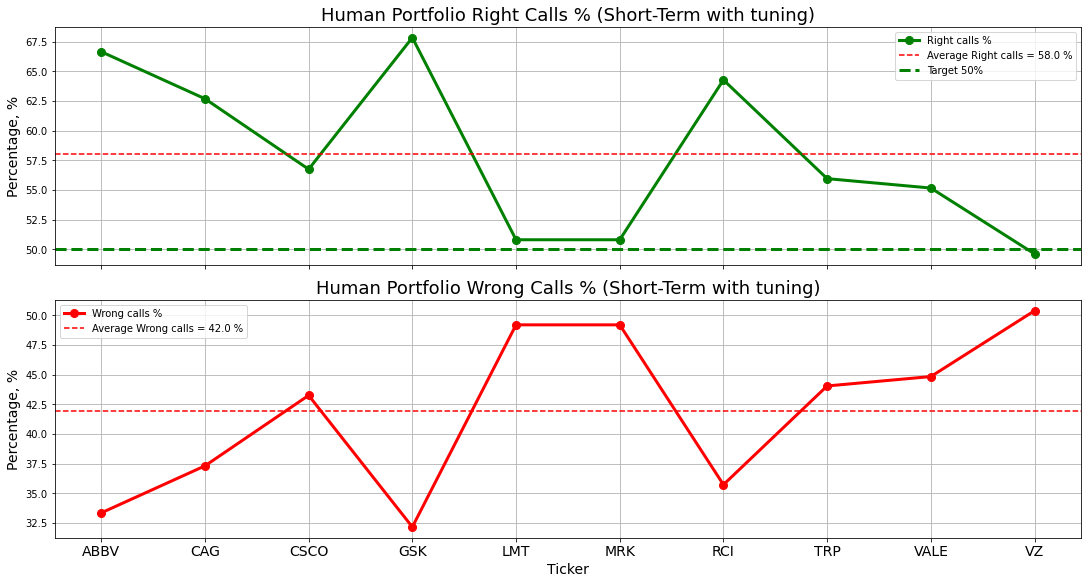

In [223]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)

ax1.plot(tuned_st_tmp['ticker'], tuned_st_tmp['Right calls %'], lw=3, marker='o',
         markersize=8, color='g', zorder=2, label='Right calls %')

ax1.set_title('Human Portfolio Right Calls % (Short-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)

label='Average Right calls = '+str(round(tuned_st_tmp['Right calls %'].mean()))+' %'
ax1.axhline(y=tuned_st_tmp['Right calls %'].mean(), color='r', ls='--', label=label)
ax1.axhline(y=50, color='green', ls='--', lw=3, label='Target 50%')

ax1.grid()
ax1.legend()

ax2.plot(tuned_st_tmp['ticker'], tuned_st_tmp['Wrong calls %'], lw=3, marker='o',
         markersize=8, color='red', zorder=2, label='Wrong calls %')

ax2.set_title('Human Portfolio Wrong Calls % (Short-Term with tuning)', fontsize=18)
ax2.set_ylabel('Percentage, %', fontsize=14)

label='Average Wrong calls = '+str(round(tuned_st_tmp['Wrong calls %'].mean()))+' %'
ax2.axhline(y=tuned_st_tmp['Wrong calls %'].mean(), color='r', ls='--', label=label)

ax2.grid()
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'ST_1yr_port_calls_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** It is good to see that the Human portfolio continued to have a high "right calls" mean percentage and all but one (VZ) company had their "right calls" percentage to be above 50%. This is evident that the LSTM model is learning efficiently. Even VZ had 49.6% right calls, with a bit more tuning it can be improved further.

In [224]:
print('===== Human Portfolio with tuning (1 yrs) =====')
print('Average percentage of right calls =', round(tuned_st_tmp['Right calls %'].mean()), '%')
print('Average percentage of wrong calls =', round(tuned_st_tmp['Wrong calls %'].mean()), '%')

===== Human Portfolio with tuning (1 yrs) =====
Average percentage of right calls = 58.0 %
Average percentage of wrong calls = 42.0 %


## How much did we make or loss?

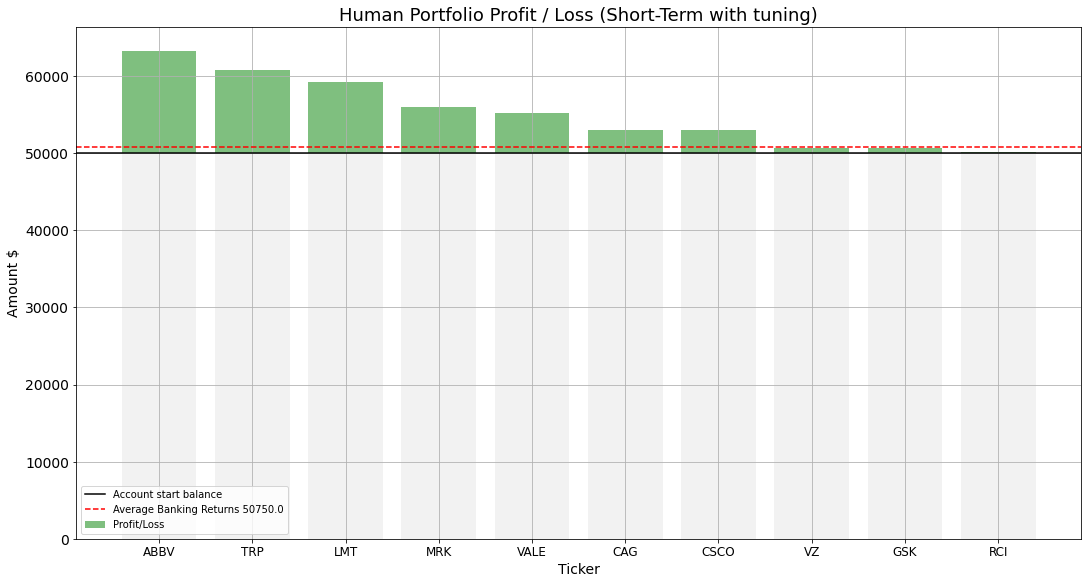

In [225]:
# plots profit and loss
plt.figure(figsize=(15,8), facecolor='white', constrained_layout=True)
tuned_st_tmp2 = ST_DK_T[['ticker', 'Account starting balance', 'Account ending balance',
                         'Profit/Loss', 'Banking returns']].sort_values('Profit/Loss', ascending=False)

plt.bar(tuned_st_tmp2['ticker'], tuned_st_tmp2['Account starting balance'], alpha=0.1, color='grey', label='',
        zorder=1)
plt.bar(tuned_st_tmp2['ticker'], tuned_st_tmp2['Profit/Loss'], alpha=0.5, color='green',
        bottom=tuned_st_tmp2['Account starting balance'], label='Profit/Loss', zorder=1)
plt.axhline(y=50000, color='k', label='Account start balance')

plt.axhline(y=tuned_st_tmp2['Banking returns'].mean(), color='r', ls='--',
            label='Average Banking Returns '+str(round(tuned_st_tmp2['Banking returns'].mean())))

plt.legend(loc='lower left')
plt.title('Human Portfolio Profit / Loss (Short-Term with tuning)', fontsize=18)
plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Amount $', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0)
plt.savefig(IMAGE_DIR_WITH_TUNING+'ST_1yr_port_pnl_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** If we were to leave the 500K investment funds in the bank @ 1.5% interest per yr, it would compound to about 50,750 in a yr (red line). However, if following our model predictions and trading strategy, all but 1 company (RCI) would have made a higher return than leaving it in the bank. This suggest that RCI is simply not a good company for short term investment because RCI actually did quite well in the long term portfolio for both the un-tune and tuned models.

In [226]:
tuned_st_tmp2

,ticker,Account starting balance,Account ending balance,Profit/Loss,Banking returns
0,ABBV,50000.0,63206.603639,13206.603639,50750.0
7,TRP,50000.0,22696.057370,10742.092526,50750.0
4,LMT,50000.0,59177.120322,9177.120322,50750.0
5,MRK,50000.0,55970.994828,5970.994828,50750.0
8,VALE,50000.0,55163.332698,5163.332698,50750.0
1,CAG,50000.0,53029.821192,3029.821192,50750.0
2,CSCO,50000.0,52959.128061,2959.128061,50750.0
9,VZ,50000.0,50657.848029,657.848029,50750.0
3,GSK,50000.0,50647.596809,647.596809,50750.0
6,RCI,50000.0,50101.698211,101.698211,50750.0


In [227]:
# sum up total portfolio profit/loss
print('===== Human Portfolio with tuning (1 yrs) =====')
tot_pnl = tuned_st_tmp2['Profit/Loss'].sum()
print(f'Portfolio total profit/loss      = $ {round(tot_pnl)}')
bank_amt = tuned_st_tmp2['Account starting balance'].sum()
tot_bank = tuned_st_tmp2['Banking returns'].sum() - (tuned_st_tmp2['Account starting balance'].mean()*len(tuned_st_tmp2.index))
print(f'Banking $ {round(bank_amt)} @ 1.5% per yr = $ {round(tot_bank)}')
print(f'Invest vs Banking over 1 yr      = $ {round(tot_pnl - tot_bank)}')

===== Human Portfolio with tuning (1 yrs) =====
Portfolio total profit/loss      = $ 51656.0
Banking $ 500000.0 @ 1.5% per yr = $ 7500.0
Invest vs Banking over 1 yr      = $ 44156.0


In [228]:
# adding result to df for comparison later
add_list = [round(tuned_st_tmp['Right calls %'].mean()),
            round(tuned_st_tmp['Wrong calls %'].mean()),
            round(tot_pnl), round(ST_DK_T['Total Percentage return (whole period)'].mean(),2),
            round(tot_bank), round(tot_pnl - tot_bank),
            round(ST_DK_T['Percentage return per yr'].mean(),2)]
add_df = pd.DataFrame(add_list, columns=['Human Portfolio w/ tuning (1 yr)'])
port_summary_df = pd.concat([port_summary_df, add_df], axis=1)
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr),Human Portfolio w/ tuning (20 yrs),Human Portfolio w/ tuning (1 yr)
0,Avg right calls %,74.00,64.00,55.00,58.00
1,Avg wrong calls %,26.00,36.00,45.00,42.00
2,Total profit/loss $,423819.00,21810.00,1129961.00,51656.00
3,Total Percentage return (whole period),84.76,4.36,225.99,10.33
4,Banking @ 1.5%/yr $,159601.00,7500.00,159601.00,7500.00
5,Invest vs Banking $,264218.00,14310.00,970360.00,44156.00
6,Percentage return per yr,4.54,4.36,12.39,10.33


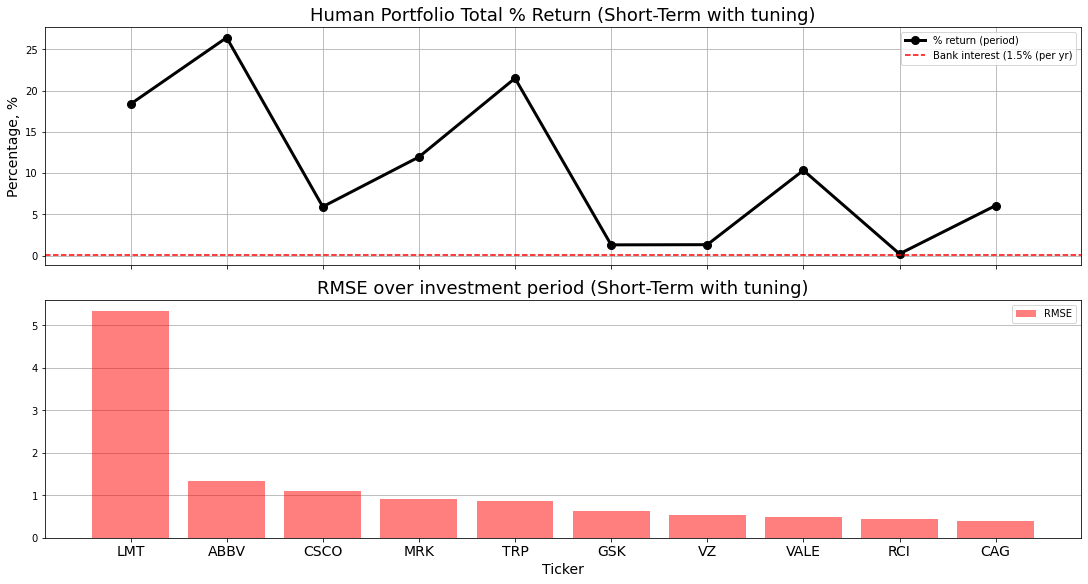

In [229]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)
tuned_st_tmp3 = ST_DK_T[['ticker', 'Total Percentage return (whole period)', 'Percentage return per yr',
                         'RMSE']].sort_values('RMSE', ascending=False)

ax1.plot(tuned_st_tmp3['ticker'], tuned_st_tmp3['Total Percentage return (whole period)'], lw=3, marker='o',
         markersize=8, color='k', zorder=2, label='% return (period)')

ax1.set_title('Human Portfolio Total % Return (Short-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)
ax1.axhline(y=0.015, color='r', ls='--', label='Bank interest (1.5% (per yr)')
ax1.grid()
ax1.legend()

ax2.bar(tuned_st_tmp3['ticker'], tuned_st_tmp3['RMSE'], lw=3, color='r', alpha=0.5, zorder=2, label='RMSE')
ax2.set_title('RMSE over investment period (Short-Term with tuning)', fontsize=18)
ax2.grid(axis='y')
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'ST_1yr_port_rtn_rmse_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** In the short term horizon, the tuned models appears to be an inverse of what we have observed before. The company (LMT) with the highest RMSE had one of the higher return % while the company (CAG) with the lowest RMSE had one of the lower return %. The companies in between again have varying performance. Thus, even in a short term horizon and with model tuning, it is evident that an investment portfolio have to consist of multiple companies to diversify the risk and to achieve collective returns.

In [230]:
tuned_st_tmp3

,ticker,Total Percentage return (whole period),Percentage return per yr,RMSE
4,LMT,18.354241,18.354241,5.326302
0,ABBV,26.413207,26.413207,1.330904
2,CSCO,5.918256,5.918256,1.108644
5,MRK,11.941990,11.941990,0.918737
7,TRP,21.484185,21.484185,0.860636
3,GSK,1.295194,1.295194,0.623814
9,VZ,1.315696,1.315696,0.524897
8,VALE,10.326665,10.326665,0.484030
6,RCI,0.203396,0.203396,0.448761
1,CAG,6.059642,6.059642,0.395584


# LONG TERM AI PORTFOLIO (with tuning)

In [231]:
# call the helper function 
strat_20yr_tuned, strat_1yr_tuned = perf_data_import(PERF_DIR_WITH_TUNING)
trans_20yr_tuned, trans_1yr_tuned = trans_data_import(TRANS_DIR_WITH_TUNING)

In [232]:
# filtering 
LT_Kmeans_T = strat_20yr_tuned[strat_20yr_tuned.ticker.isin(kmeans_portfolio.ticker.unique())].reset_index(drop=True)
LT_TRANS_Kmeans_T = trans_20yr_tuned[trans_20yr_tuned.ticker.isin(kmeans_portfolio.ticker.unique())].reset_index(drop=True)

## How often did we get it right?

<ipython-input-233-0cba1954f3bc>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(kmeans_tuned_lt_tmp.ticker, fontsize=12)


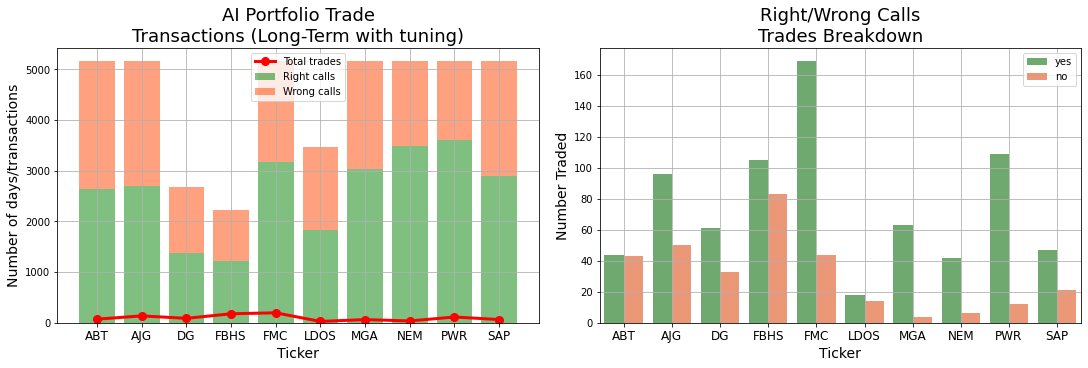

In [233]:
# plots trade transactions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white', constrained_layout=True)
kmeans_tuned_lt_tmp = LT_Kmeans_T[['ticker', 'Total number of trade days', 'Number of right calls',
                                   'Right calls %', 'Number of wrong calls', 'Wrong calls %',
                                   'Total trades conducted']]

ax1.bar(kmeans_tuned_lt_tmp['ticker'], kmeans_tuned_lt_tmp['Number of right calls'], alpha=0.5, color='green',
        zorder=1, label='Right calls')
ax1.bar(kmeans_tuned_lt_tmp['ticker'], kmeans_tuned_lt_tmp['Number of wrong calls'], alpha=0.5, color='orangered',
        zorder=1, label='Wrong calls', bottom=kmeans_tuned_lt_tmp['Number of right calls'])

ax1.plot(kmeans_tuned_lt_tmp['ticker'], kmeans_tuned_lt_tmp['Total trades conducted'], lw=3, marker='o', markersize=8,
         label='Total trades', color='red', zorder=2);

ax1.set_title('AI Portfolio Trade\nTransactions (Long-Term with tuning)', fontsize=18)
ax1.set_xlabel('Ticker', fontsize=14)
ax1.set_xticklabels(kmeans_tuned_lt_tmp.ticker, fontsize=12)
ax1.set_ylabel('Number of days/transactions', fontsize=14)
ax1.grid(zorder=0)
ax1.legend()

# plot right/wrong trades breakdown
kmeans_tuned_lt_tmp_breakdown = LT_TRANS_Kmeans_T[LT_TRANS_Kmeans_T['total_plus_comm_fees']!=0]
sns.barplot(x='ticker', y='total_plus_comm_fees', data=kmeans_tuned_lt_tmp_breakdown, hue='right_call?',
            hue_order=['yes', 'no'], palette=['green', 'orangered'], alpha=0.6, dodge=True, orient='v',
            estimator=len, ax=ax2)
ax2.set_title('Right/Wrong Calls\nTrades Breakdown', fontsize=18)
ax2.set_xlabel('Ticker', fontsize=14)
ax2.set_xticklabels(kmeans_tuned_lt_tmp.ticker, fontsize=12)
ax2.set_ylabel('Number Traded', fontsize=14)
ax2.legend()
ax2.grid(zorder=0)

plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_LT_20yrs_port_trans_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** In the AI portfolio, we continued to observe that despite having a high number of "right calls", the number of trades continued to be very low. As mentioned, this is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

We also noticed that DG, FBHS and LDOS had lower total number of trade days (i.e. right calls + wrong calls). This is because of the fact that these three companies had listing age lesser than 20 yrs resulting in lesser trade days.

Fortunately, the number of "right calls" for each company was higher than the number of "wrong calls".

In [234]:
kmeans_tuned_lt_tmp

,ticker,Total number of trade days,Number of right calls,Right calls %,Number of wrong calls,Wrong calls %,Total trades conducted
0,ABT,5167,2633,50.938286,2536,49.061714,72
1,AJG,5166,2703,52.322880,2463,47.677120,136
2,DG,2684,1384,51.564829,1300,48.435171,88
3,FBHS,2221,1209,54.434939,1012,45.565061,178
4,FMC,5167,3169,61.307796,2000,38.692204,197
5,LDOS,3459,1840,53.194565,1619,46.805435,27
6,MGA,5167,3026,58.563964,2141,41.436036,63
7,NEM,5166,3483,67.421603,1683,32.578397,37
8,PWR,5166,3610,69.879985,1556,30.120015,114
9,SAP,5167,2899,56.106058,2268,43.893942,64


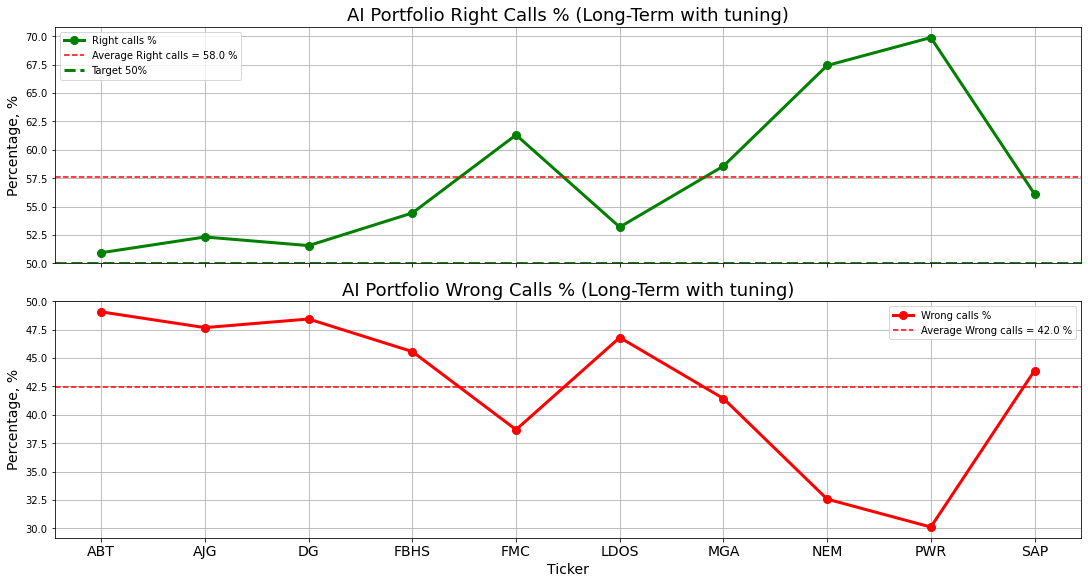

In [235]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)

ax1.plot(kmeans_tuned_lt_tmp['ticker'], kmeans_tuned_lt_tmp['Right calls %'], lw=3, marker='o',
         markersize=8, color='g', zorder=2, label='Right calls %')

ax1.set_title('AI Portfolio Right Calls % (Long-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)

label='Average Right calls = '+str(round(kmeans_tuned_lt_tmp['Right calls %'].mean()))+' %'
ax1.axhline(y=kmeans_tuned_lt_tmp['Right calls %'].mean(), color='r', ls='--', label=label)
ax1.axhline(y=50, color='green', ls='--', lw=3, label='Target 50%')
            
ax1.grid()
ax1.legend()

ax2.plot(kmeans_tuned_lt_tmp['ticker'], kmeans_tuned_lt_tmp['Wrong calls %'], lw=3, marker='o',
         markersize=8, color='red', zorder=2, label='Wrong calls %')

ax2.set_title('AI Portfolio Wrong Calls % (Long-Term with tuning)', fontsize=18)
ax2.set_ylabel('Percentage, %', fontsize=14)

label='Average Wrong calls = '+str(round(kmeans_tuned_lt_tmp['Wrong calls %'].mean()))+' %'
ax2.axhline(y=kmeans_tuned_lt_tmp['Wrong calls %'].mean(), color='r', ls='--', label=label)

ax2.grid()
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_LT_20yrs_port_calls_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With the AI portfolio, although the "right calls" mean percentage is lower than the un-tune portfolio. It is is still above 50% so it is still acceptable and proved that the LSTM model is learning efficiently.

In [236]:
print('===== AI Portfolio with tuning (20yrs) =====')
print('Average percentage of right calls =', round(kmeans_tuned_lt_tmp['Right calls %'].mean()), '%')
print('Average percentage of wrong calls =', round(kmeans_tuned_lt_tmp['Wrong calls %'].mean()), '%')

===== AI Portfolio with tuning (20yrs) =====
Average percentage of right calls = 58.0 %
Average percentage of wrong calls = 42.0 %


## How much did we make or loss?

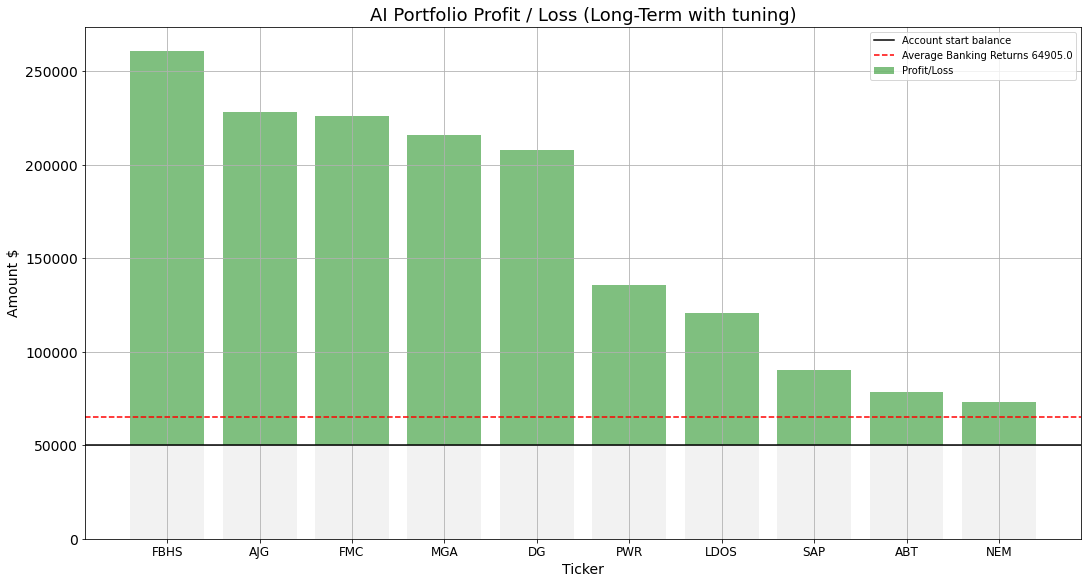

In [237]:
# plots profit and loss
plt.figure(figsize=(15,8), facecolor='white', constrained_layout=True)
kmeans_tuned_lt_tmp2 = LT_Kmeans_T[['ticker', 'Account starting balance', 'Account ending balance',
                                    'Profit/Loss', 'Banking returns']].sort_values('Profit/Loss', ascending=False)

plt.bar(kmeans_tuned_lt_tmp2['ticker'], kmeans_tuned_lt_tmp2['Account starting balance'], alpha=0.1, color='grey',
        label='', zorder=1)
plt.bar(kmeans_tuned_lt_tmp2['ticker'], kmeans_tuned_lt_tmp2['Profit/Loss'], alpha=0.5, color='green',
        bottom=kmeans_tuned_lt_tmp2['Account starting balance'], label='Profit/Loss', zorder=1)
plt.axhline(y=50000, color='k', label='Account start balance')

plt.axhline(y=kmeans_tuned_lt_tmp2['Banking returns'].mean(), color='r', ls='--',
            label='Average Banking Returns '+str(round(kmeans_tuned_lt_tmp2['Banking returns'].mean())))

plt.legend()
plt.title('AI Portfolio Profit / Loss (Long-Term with tuning)', fontsize=18)
plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Amount $', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0)
plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_LT_20yrs_port_pnl_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With AI portfolio, profits was good across the board with all companies having higher returns than leaving the 500K in the bank.

In [238]:
kmeans_tuned_lt_tmp2

,ticker,Account starting balance,Account ending balance,Profit/Loss,Banking returns
3,FBHS,50000.0,260665.186712,210665.186712,57169.50
1,AJG,50000.0,228257.802355,178257.802355,67342.75
4,FMC,50000.0,162399.307031,175764.153833,67342.75
6,MGA,50000.0,215618.551141,165618.551141,67342.75
2,DG,50000.0,207720.653081,157720.653081,58897.45
8,PWR,50000.0,135488.852031,85488.852031,67342.75
5,LDOS,50000.0,120777.225754,70777.225754,61587.79
9,SAP,50000.0,90155.124168,40155.124168,67342.75
0,ABT,50000.0,78691.104183,28691.104183,67342.75
7,NEM,50000.0,72999.230895,22999.230895,67342.75


In [239]:
# sum up total portfolio profit/loss
print('===== AI Portfolio with tuning (20yrs) =====')
tot_pnl = kmeans_tuned_lt_tmp2['Profit/Loss'].sum()
print(f'Portfolio total profit/loss      = $ {round(tot_pnl)}')
bank_amt = kmeans_tuned_lt_tmp2['Account starting balance'].sum()
tot_bank = kmeans_tuned_lt_tmp2['Banking returns'].sum() - (kmeans_tuned_lt_tmp2['Account starting balance'].mean()*len(kmeans_tuned_lt_tmp2.index))
print(f'Banking $ {round(bank_amt)} @ 1.5% per yr = $ {round(tot_bank)}')
print(f'Invest vs Banking over 20 yrs    = $ {round(tot_pnl - tot_bank)}')

===== AI Portfolio with tuning (20yrs) =====
Portfolio total profit/loss      = $ 1136138.0
Banking $ 500000.0 @ 1.5% per yr = $ 149054.0
Invest vs Banking over 20 yrs    = $ 987084.0


In [240]:
# adding result to df for comparison later
add_list = [round(kmeans_tuned_lt_tmp['Right calls %'].mean()),
            round(kmeans_tuned_lt_tmp['Wrong calls %'].mean()),
            round(tot_pnl), round(LT_Kmeans_T['Total Percentage return (whole period)'].mean(),2),
            round(tot_bank), round(tot_pnl - tot_bank),
            round(LT_Kmeans_T['Percentage return per yr'].mean(),2)]
add_df = pd.DataFrame(add_list, columns=['AI Portfolio w/ tuning (20 yrs)'])
port_summary_df = pd.concat([port_summary_df, add_df], axis=1)
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr),Human Portfolio w/ tuning (20 yrs),Human Portfolio w/ tuning (1 yr),AI Portfolio w/ tuning (20 yrs)
0,Avg right calls %,74.00,64.00,55.00,58.00,58.00
1,Avg wrong calls %,26.00,36.00,45.00,42.00,42.00
2,Total profit/loss $,423819.00,21810.00,1129961.00,51656.00,1136138.00
3,Total Percentage return (whole period),84.76,4.36,225.99,10.33,227.23
4,Banking @ 1.5%/yr $,159601.00,7500.00,159601.00,7500.00,149054.00
5,Invest vs Banking $,264218.00,14310.00,970360.00,44156.00,987084.00
6,Percentage return per yr,4.54,4.36,12.39,10.33,15.53


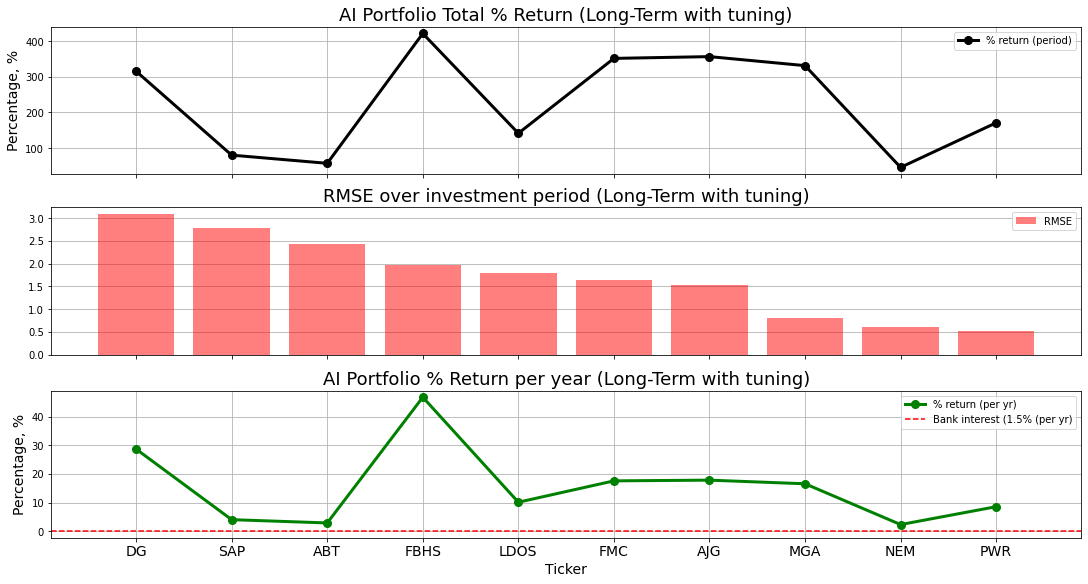

In [241]:
# plots percentages
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)
kmeans_tuned_lt_tmp3 = LT_Kmeans_T[['ticker', 'Total Percentage return (whole period)',
                                    'Percentage return per yr', 'RMSE']].sort_values('RMSE', ascending=False)

ax1.plot(kmeans_tuned_lt_tmp3['ticker'], kmeans_tuned_lt_tmp3['Total Percentage return (whole period)'], lw=3,
         marker='o', markersize=8, color='k', zorder=2, label='% return (period)')

ax1.set_title('AI Portfolio Total % Return (Long-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)
ax1.grid()
ax1.legend()

ax2.bar(kmeans_tuned_lt_tmp3['ticker'], kmeans_tuned_lt_tmp3['RMSE'], lw=3, color='r', alpha=0.5, zorder=2,
        label='RMSE')
ax2.set_title('RMSE over investment period (Long-Term with tuning)', fontsize=18)
ax2.grid(axis='y')
ax2.legend()

ax3.plot(kmeans_tuned_lt_tmp3['ticker'], kmeans_tuned_lt_tmp3['Percentage return per yr'], lw=3, marker='o',
         markersize=8, color='green', zorder=2, label='% return (per yr)')

ax3.set_title('AI Portfolio % Return per year (Long-Term with tuning)', fontsize=18)
ax3.set_ylabel('Percentage, %', fontsize=14)
ax3.axhline(y=0.015, color='r', ls='--', label='Bank interest (1.5% (per yr)')
ax3.grid()
ax3.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_LT_20yrs_port_rtn_rmse_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With AI portfolio, we continued to see the observations made in the un-tune and tuned models. As such we re-iterate that an investment portfolio have to consist of multiple companies to diversify the risk and to achieve collective returns. More importantly, the tuned models continued to have a higher return percentage than leaving the money in the bank.

In [242]:
kmeans_tuned_lt_tmp3

,ticker,Total Percentage return (whole period),Percentage return per yr,RMSE
2,DG,315.441306,28.676482,3.080939
9,SAP,80.310248,4.015512,2.778961
0,ABT,57.382208,2.869110,2.434866
3,FBHS,421.330373,46.814486,1.967892
5,LDOS,141.554452,10.111032,1.786178
4,FMC,351.528308,17.576415,1.645045
1,AJG,356.515605,17.825780,1.536585
6,MGA,331.237102,16.561855,0.795770
7,NEM,45.998462,2.299923,0.617394
8,PWR,170.977704,8.548885,0.530799


# SHORT TERM AI PORTFOLIO (with tuning)

In [243]:
# filtering 
ST_Kmeans_T = strat_1yr_tuned[strat_1yr_tuned.ticker.isin(kmeans_portfolio.ticker.unique())].reset_index(drop=True)
ST_TRANS_Kmeans_T = trans_1yr_tuned[trans_1yr_tuned.ticker.isin(kmeans_portfolio.ticker.unique())].reset_index(drop=True)

## How often did we get it right?

<ipython-input-244-287913759450>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(kmeans_tuned_st_tmp.ticker, fontsize=12)


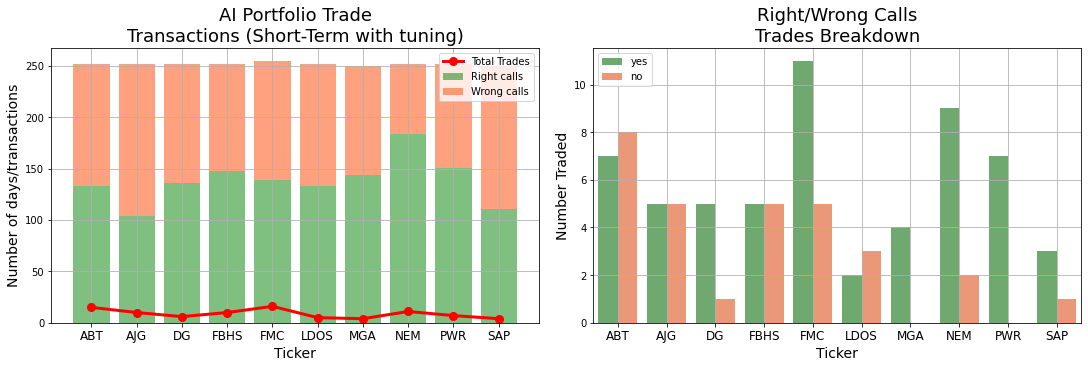

In [244]:
# plots trade transactions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white', constrained_layout=True)
kmeans_tuned_st_tmp = ST_Kmeans_T[['ticker', 'Total number of trade days', 'Number of right calls',
                                   'Right calls %', 'Number of wrong calls', 'Wrong calls %',
                                   'Total trades conducted']]

ax1.bar(kmeans_tuned_st_tmp['ticker'], kmeans_tuned_st_tmp['Number of right calls'], alpha=0.5, color='green',
        label= 'Right calls', zorder=1)
ax1.bar(kmeans_tuned_st_tmp['ticker'], kmeans_tuned_st_tmp['Number of wrong calls'], alpha=0.5, color='orangered',
        zorder=1, label='Wrong calls', bottom=kmeans_tuned_st_tmp['Number of right calls'])

ax1.plot(kmeans_tuned_st_tmp['ticker'], kmeans_tuned_st_tmp['Total trades conducted'], lw=3, marker='o',
         markersize=8, label='Total Trades', color='red', zorder=2);

ax1.set_title('AI Portfolio Trade\nTransactions (Short-Term with tuning)', fontsize=18)
ax1.set_xlabel('Ticker', fontsize=14)
ax1.set_xticklabels(kmeans_tuned_st_tmp.ticker, fontsize=12)
ax1.set_ylabel('Number of days/transactions', fontsize=14)
ax1.grid(zorder=0)
ax1.legend()

# plot right/wrong trades breakdown
kmeans_tuned_st_tmp_breakdown = ST_TRANS_Kmeans_T[ST_TRANS_Kmeans_T['total_plus_comm_fees']!=0]
sns.barplot(x='ticker', y='total_plus_comm_fees', data=kmeans_tuned_st_tmp_breakdown, hue='right_call?',
            hue_order=['yes', 'no'], palette=['green', 'orangered'], alpha=0.6, dodge=True, orient='v',
            estimator=len, ax=ax2)
ax2.set_title('Right/Wrong Calls\nTrades Breakdown', fontsize=18)
ax2.set_xlabel('Ticker', fontsize=14)
ax2.set_xticklabels(kmeans_tuned_st_tmp.ticker, fontsize=12)
ax2.set_ylabel('Number Traded', fontsize=14)
ax2.legend()
ax2.grid(zorder=0)

plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_ST_1yr_port_trans_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** Similar to the long term portfolio, despite having an overwhelming number of "right calls" there were not many trades conducted. This is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

The number of "right calls" for most companies was higher than the number of "wrong calls". The only two exceptions were ABT and LDOS.

In [245]:
kmeans_tuned_st_tmp

,ticker,Total number of trade days,Number of right calls,Right calls %,Number of wrong calls,Wrong calls %,Total trades conducted
0,ABT,252,133,52.777778,119,47.222222,15
1,AJG,252,104,41.269841,148,58.730159,10
2,DG,252,136,53.968254,116,46.031746,6
3,FBHS,252,148,58.730159,104,41.269841,10
4,FMC,253,139,54.509804,116,45.490196,16
5,LDOS,252,133,52.777778,119,47.222222,5
6,MGA,250,144,57.600000,106,42.400000,4
7,NEM,252,184,73.015873,68,26.984127,11
8,PWR,252,151,59.920635,101,40.079365,7
9,SAP,250,111,44.400000,139,55.600000,4


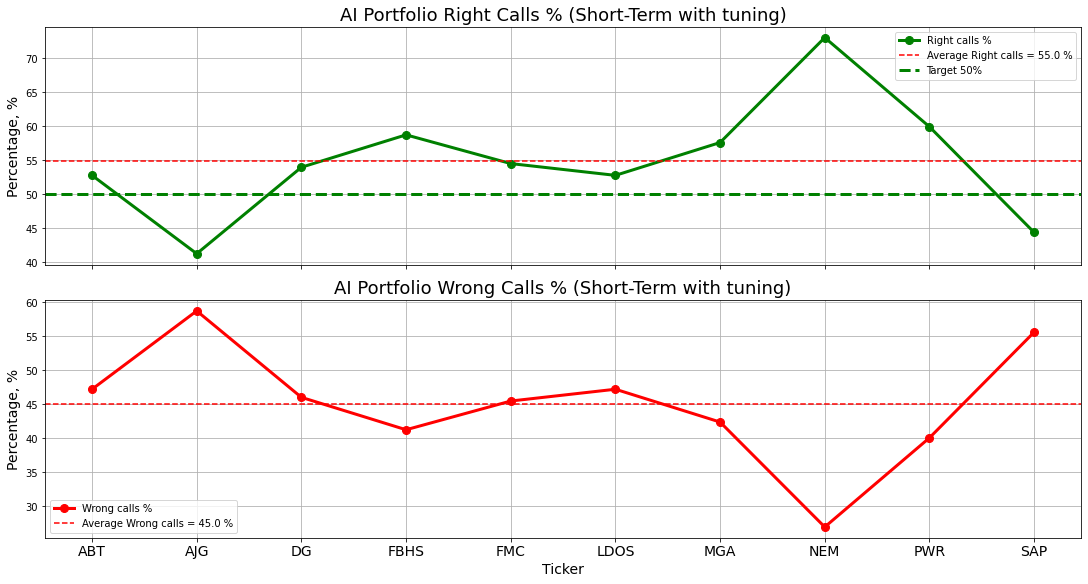

In [246]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)

ax1.plot(kmeans_tuned_st_tmp['ticker'], kmeans_tuned_st_tmp['Right calls %'], lw=3, marker='o',
         markersize=8, color='g', zorder=2, label='Right calls %')

ax1.set_title('AI Portfolio Right Calls % (Short-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)

label='Average Right calls = '+str(round(kmeans_tuned_st_tmp['Right calls %'].mean()))+' %'
ax1.axhline(y=kmeans_tuned_st_tmp['Right calls %'].mean(), color='r', ls='--', label=label)
ax1.axhline(y=50, color='green', ls='--', lw=3, label='Target 50%')

ax1.grid()
ax1.legend()

ax2.plot(kmeans_tuned_st_tmp['ticker'], kmeans_tuned_st_tmp['Wrong calls %'], lw=3, marker='o',
         markersize=8, color='red', zorder=2, label='Wrong calls %')

ax2.set_title('AI Portfolio Wrong Calls % (Short-Term with tuning)', fontsize=18)
ax2.set_ylabel('Percentage, %', fontsize=14)

label='Average Wrong calls = '+str(round(kmeans_tuned_st_tmp['Wrong calls %'].mean()))+' %'
ax2.axhline(y=kmeans_tuned_st_tmp['Wrong calls %'].mean(), color='r', ls='--', label=label)

ax2.grid()
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_ST_1yr_port_calls_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With the AI portfolio, although the "right calls" mean percentage is above 50%. Two companies (AJG, SAP) fell below 50%. This suggests that either the models had not been tuned sufficiently or these companies are not suitable for short term investment. A quick review of the prediction plots of these two companies revealed that the models had not been tuned sufficiently to learn the features pattern in the recent 1 yr period. The below plots helps to illustrate the point.

![AJG](images/with_keras_tuning/AJGpred_vs_actual_all_seq.png "AJG")
![SAP](images/with_keras_tuning/SAPpred_vs_actual_all_seq.png "SAP")

In [247]:
print('===== AI Portfolio with tuning (1 yrs) =====')
print('Average percentage of right calls =', round(kmeans_tuned_st_tmp['Right calls %'].mean()), '%')
print('Average percentage of wrong calls =', round(kmeans_tuned_st_tmp['Wrong calls %'].mean()), '%')

===== AI Portfolio with tuning (1 yrs) =====
Average percentage of right calls = 55.0 %
Average percentage of wrong calls = 45.0 %


## How much did we make or loss?

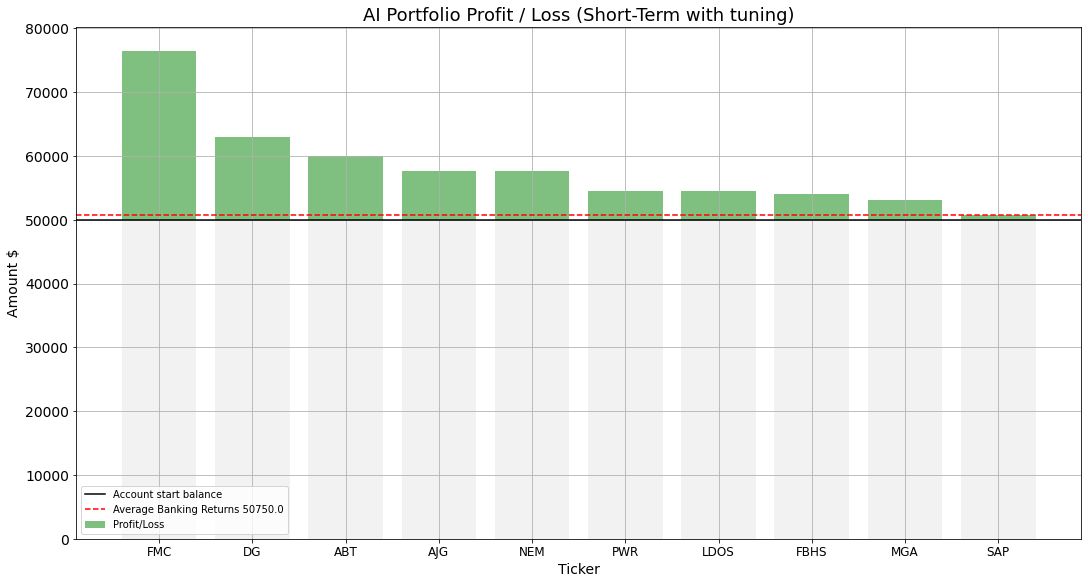

In [248]:
# plots profit and loss
plt.figure(figsize=(15,8), facecolor='white', constrained_layout=True)
kmeans_tuned_st_tmp2 = ST_Kmeans_T[['ticker', 'Account starting balance', 'Account ending balance',
                                    'Profit/Loss', 'Banking returns']].sort_values('Profit/Loss', ascending=False)

plt.bar(kmeans_tuned_st_tmp2['ticker'], kmeans_tuned_st_tmp2['Account starting balance'], alpha=0.1,
        color='grey', label='', zorder=1)
plt.bar(kmeans_tuned_st_tmp2['ticker'], kmeans_tuned_st_tmp2['Profit/Loss'], alpha=0.5, color='green',
        bottom=kmeans_tuned_st_tmp2['Account starting balance'], label='Profit/Loss', zorder=1)
plt.axhline(y=50000, color='k', label='Account start balance')

plt.axhline(y=kmeans_tuned_st_tmp2['Banking returns'].mean(), color='r', ls='--',
            label='Average Banking Returns '+str(round(kmeans_tuned_st_tmp2['Banking returns'].mean())))

plt.legend(loc='lower left')
plt.title('AI Portfolio Profit / Loss (Short-Term with tuning)', fontsize=18)
plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Amount $', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0)
plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_ST_1yr_port_pnl_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With the AI portfolio, we can see that all companies had higher returns than leaving the 500K in the bank.

In [249]:
kmeans_tuned_st_tmp2

,ticker,Account starting balance,Account ending balance,Profit/Loss,Banking returns
4,FMC,50000.0,13035.206030,26400.052832,50750.0
2,DG,50000.0,62936.842557,12936.842557,50750.0
0,ABT,50000.0,59946.333919,9946.333919,50750.0
1,AJG,50000.0,57671.769231,7671.769231,50750.0
7,NEM,50000.0,57590.679775,7590.679775,50750.0
8,PWR,50000.0,54553.347666,4553.347666,50750.0
5,LDOS,50000.0,54472.449645,4472.449645,50750.0
3,FBHS,50000.0,54064.985766,4064.985766,50750.0
6,MGA,50000.0,53005.261367,3005.261367,50750.0
9,SAP,50000.0,50778.750655,778.750655,50750.0


In [250]:
# sum up total portfolio profit/loss
print('===== AI Portfolio with tuning (1 yrs) =====')
tot_pnl = kmeans_tuned_st_tmp2['Profit/Loss'].sum()
print(f'Portfolio total profit/loss      = $ {round(tot_pnl)}')
bank_amt = kmeans_tuned_st_tmp2['Account starting balance'].sum()
tot_bank = kmeans_tuned_st_tmp2['Banking returns'].sum() - (tuned_st_tmp2['Account starting balance'].mean()*len(kmeans_tuned_st_tmp2.index))
print(f'Banking $ {round(bank_amt)} @ 1.5% per yr = $ {round(tot_bank)}')
print(f'Invest vs Banking over 1 yr      = $ {round(tot_pnl - tot_bank)}')

===== AI Portfolio with tuning (1 yrs) =====
Portfolio total profit/loss      = $ 81420.0
Banking $ 500000.0 @ 1.5% per yr = $ 7500.0
Invest vs Banking over 1 yr      = $ 73920.0


In [251]:
# adding result to df for comparison later
add_list = [round(kmeans_tuned_st_tmp['Right calls %'].mean()),
            round(kmeans_tuned_st_tmp['Wrong calls %'].mean()),
            round(tot_pnl), round(ST_Kmeans_T['Total Percentage return (whole period)'].mean(),2),
            round(tot_bank), round(tot_pnl - tot_bank),
            round(ST_Kmeans_T['Percentage return per yr'].mean(),2)]
add_df = pd.DataFrame(add_list, columns=['AI Portfolio w/ tuning (1 yr)'])
port_summary_df = pd.concat([port_summary_df, add_df], axis=1)
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr),Human Portfolio w/ tuning (20 yrs),Human Portfolio w/ tuning (1 yr),AI Portfolio w/ tuning (20 yrs),AI Portfolio w/ tuning (1 yr)
0,Avg right calls %,74.00,64.00,55.00,58.00,58.00,55.00
1,Avg wrong calls %,26.00,36.00,45.00,42.00,42.00,45.00
2,Total profit/loss $,423819.00,21810.00,1129961.00,51656.00,1136138.00,81420.00
3,Total Percentage return (whole period),84.76,4.36,225.99,10.33,227.23,16.28
4,Banking @ 1.5%/yr $,159601.00,7500.00,159601.00,7500.00,149054.00,7500.00
5,Invest vs Banking $,264218.00,14310.00,970360.00,44156.00,987084.00,73920.00
6,Percentage return per yr,4.54,4.36,12.39,10.33,15.53,16.28


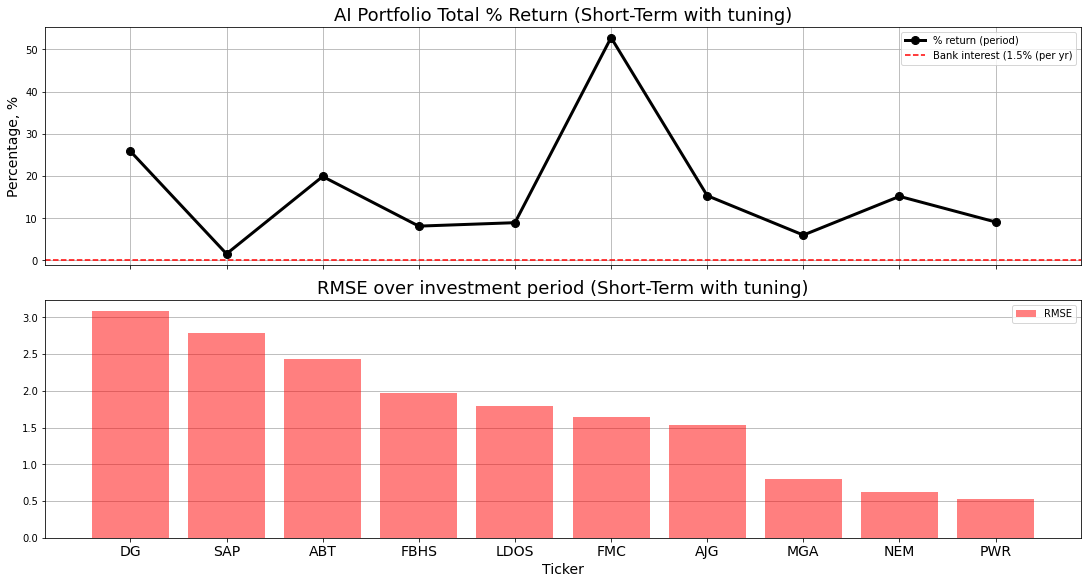

In [252]:
# plots percentages
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), facecolor='white', sharex=True, constrained_layout=True)
kmeans_tuned_st_tmp3 = ST_Kmeans_T[['ticker', 'Total Percentage return (whole period)',
                                    'Percentage return per yr', 'RMSE']].sort_values('RMSE', ascending=False)

ax1.plot(kmeans_tuned_st_tmp3['ticker'], kmeans_tuned_st_tmp3['Total Percentage return (whole period)'], lw=3,
         marker='o', markersize=8, color='k', zorder=2, label='% return (period)')

ax1.set_title('AI Portfolio Total % Return (Short-Term with tuning)', fontsize=18)
ax1.set_ylabel('Percentage, %', fontsize=14)
ax1.axhline(y=0.015, color='r', ls='--', label='Bank interest (1.5% (per yr)')
ax1.grid()
ax1.legend()

ax2.bar(kmeans_tuned_st_tmp3['ticker'], kmeans_tuned_st_tmp3['RMSE'], lw=3, color='r', alpha=0.5, zorder=2, label='RMSE')
ax2.set_title('RMSE over investment period (Short-Term with tuning)', fontsize=18)
ax2.grid(axis='y')
ax2.legend()

plt.xlabel('Ticker', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(IMAGE_DIR_WITH_TUNING+'Kmeans_ST_1yr_port_rtn_rmse_with_tuning.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

**Note:** With the AI portfolio, we continue to re-interate that an investment portfolio have to consist of multiple companies to diversify the risk and to achieve collective returns.

In [253]:
kmeans_tuned_st_tmp3

,ticker,Total Percentage return (whole period),Percentage return per yr,RMSE
2,DG,25.873685,25.873685,3.080939
9,SAP,1.557501,1.557501,2.778961
0,ABT,19.892668,19.892668,2.434866
3,FBHS,8.129972,8.129972,1.967892
5,LDOS,8.944899,8.944899,1.786178
4,FMC,52.800106,52.800106,1.645045
1,AJG,15.343538,15.343538,1.536585
6,MGA,6.010523,6.010523,0.795770
7,NEM,15.181360,15.181360,0.617394
8,PWR,9.106695,9.106695,0.530799


# PORTFOLIO ANALYSIS SUMMARY

In [254]:
# portfolio comparision summary by period by tuning
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr),Human Portfolio w/ tuning (20 yrs),Human Portfolio w/ tuning (1 yr),AI Portfolio w/ tuning (20 yrs),AI Portfolio w/ tuning (1 yr)
0,Avg right calls %,74.00,64.00,55.00,58.00,58.00,55.00
1,Avg wrong calls %,26.00,36.00,45.00,42.00,42.00,45.00
2,Total profit/loss $,423819.00,21810.00,1129961.00,51656.00,1136138.00,81420.00
3,Total Percentage return (whole period),84.76,4.36,225.99,10.33,227.23,16.28
4,Banking @ 1.5%/yr $,159601.00,7500.00,159601.00,7500.00,149054.00,7500.00
5,Invest vs Banking $,264218.00,14310.00,970360.00,44156.00,987084.00,73920.00
6,Percentage return per yr,4.54,4.36,12.39,10.33,15.53,16.28


## How often did we get it right?

<ipython-input-255-2efde4975d94>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls, fontsize=10)
<ipython-input-255-2efde4975d94>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls, fontsize=10)


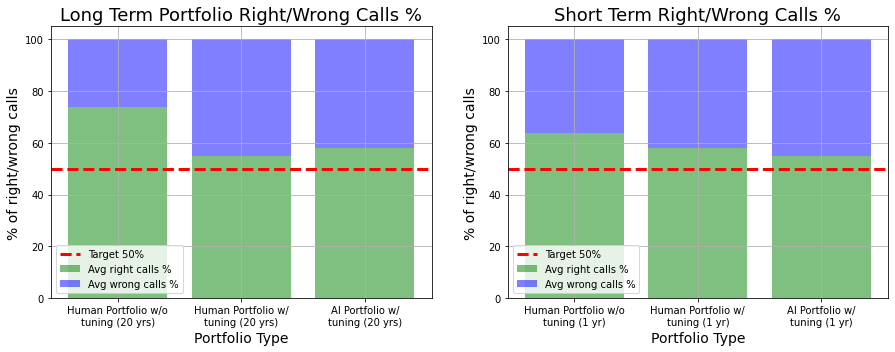

In [255]:
# plots portfolio pnl
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor='white')
plt.subplots_adjust(wspace=0.2, hspace=0.4)

''' ========== % plots =========='''
# filtering the data for LT 
plot1_data = port_summary_df.loc[0:1,['Human Portfolio w/o tuning (20 yrs)', 'Human Portfolio w/ tuning (20 yrs)',
                                      'AI Portfolio w/ tuning (20 yrs)']].T
plot1_data.rename(columns={0: 'Avg right calls %',
                           1: 'Avg wrong calls %'}, inplace=True)

# plots for LT
ax1.bar(plot1_data.index, plot1_data['Avg right calls %'], 
        alpha=0.5, color='green', label='Avg right calls %')
ax1.bar(plot1_data.index, plot1_data['Avg wrong calls %'], bottom=plot1_data['Avg right calls %'],
        alpha=0.5, color='blue', label='Avg wrong calls %')
ax1.axhline(50,  color='red', ls='--', lw=3, label='Target 50%')
ax1.set_title('Long Term Portfolio Right/Wrong Calls %', fontsize=18)
ax1.set_xlabel('Portfolio Type', fontsize=14)
ax1.set_ylabel('% of right/wrong calls', fontsize=14)
# custom labels
lbls = [lbl.replace(' t', '\nt')  for lbl in plot1_data.index]
ax1.set_xticklabels(lbls, fontsize=10)
ax1.grid()
ax1.legend(loc='lower left')


# filtering the data for ST
plot2_data = port_summary_df.loc[0:1,['Human Portfolio w/o tuning (1 yr)', 'Human Portfolio w/ tuning (1 yr)',
                                     'AI Portfolio w/ tuning (1 yr)']].T    
plot2_data.rename(columns={0: 'Avg right calls %',
                           1: 'Avg wrong calls %'}, inplace=True)

# plots for ST
ax2.bar(plot2_data.index, plot2_data['Avg right calls %'], 
        alpha=0.5, color='green', label='Avg right calls %')
ax2.bar(plot2_data.index, plot2_data['Avg wrong calls %'], bottom=plot2_data['Avg right calls %'],
        alpha=0.5, color='blue', label='Avg wrong calls %')
ax2.axhline(50,  color='red', ls='--', lw=3, label='Target 50%')
ax2.set_title('Short Term Right/Wrong Calls %', fontsize=18)
ax2.set_xlabel('Portfolio Type', fontsize=14)
ax2.set_ylabel('% of right/wrong calls', fontsize=14)
# custom labels
lbls = [lbl.replace(' t', '\nt')  for lbl in plot2_data.index]
ax2.set_xticklabels(lbls, fontsize=10)
ax2.grid()
ax2.legend(loc='lower left')

# saving the figure
plt.savefig(IMAGE_DIR+'portfolio_calls_comparison.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

## How much did we make or loss?

<ipython-input-256-9c9e8a4f1b82>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls, fontsize=10)
<ipython-input-256-9c9e8a4f1b82>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls, fontsize=10)
<ipython-input-256-9c9e8a4f1b82>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(lbls, fontsize=10)
<ipython-input-256-9c9e8a4f1b82>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(lbls, fontsize=10)


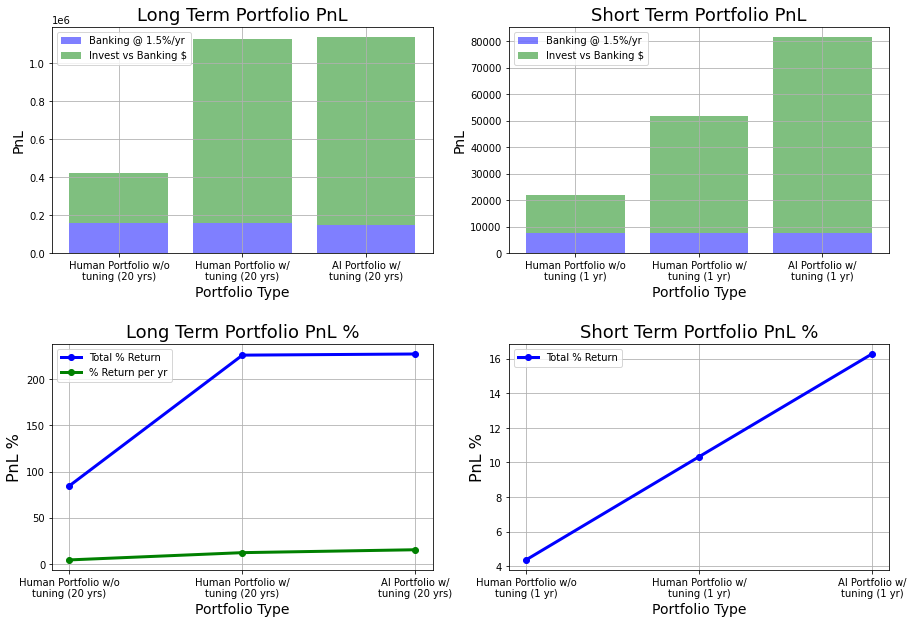

In [256]:
# plots portfolio pnl
fig, [(ax1, ax2), (ax3,ax4)] = plt.subplots(2,2, figsize=(15,10), facecolor='white')
plt.subplots_adjust(wspace=0.2, hspace=0.4)

''' ========== values plots =========='''
# filtering the data for LT
plot1_data = port_summary_df.loc[2:,['Human Portfolio w/o tuning (20 yrs)', 'Human Portfolio w/ tuning (20 yrs)',
                                     'AI Portfolio w/ tuning (20 yrs)']].T
plot1_data.rename(columns={2: 'Total profit/loss $',
                           3: 'Total Percentage return (whole period)',
                           4: 'Banking @ 1.5%/yr',
                           5: 'Invest vs Banking $',
                           6: 'Percentage return per yr'}, inplace=True)

# plots for LT
ax1.bar(plot1_data.index, plot1_data['Banking @ 1.5%/yr'], 
        alpha=0.5, color='blue', label='Banking @ 1.5%/yr')
ax1.bar(plot1_data.index, plot1_data['Invest vs Banking $'], bottom=plot1_data['Banking @ 1.5%/yr'],
        alpha=0.5, color='green', label='Invest vs Banking $')
ax1.set_title('Long Term Portfolio PnL', fontsize=18)
ax1.set_xlabel('Portfolio Type', fontsize=14)
ax1.set_ylabel('PnL', fontsize=14)
# custom labels
lbls = [lbl.replace(' t', '\nt')  for lbl in plot1_data.index]
ax1.set_xticklabels(lbls, fontsize=10)
ax1.grid()
ax1.legend()


# filtering the data for ST
plot2_data = port_summary_df.loc[2:,['Human Portfolio w/o tuning (1 yr)', 'Human Portfolio w/ tuning (1 yr)',
                                     'AI Portfolio w/ tuning (1 yr)']].T    
plot2_data.rename(columns={2: 'Total profit/loss $',
                           3: 'Total Percentage return (whole period)',
                           4: 'Banking @ 1.5%/yr',
                           5: 'Invest vs Banking $',
                           6: 'Percentage return per yr'}, inplace=True)

# plots for ST
ax2.bar(plot2_data.index, plot2_data['Banking @ 1.5%/yr'], 
        alpha=0.5, color='blue', label='Banking @ 1.5%/yr')
ax2.bar(plot2_data.index, plot2_data['Invest vs Banking $'], bottom=plot2_data['Banking @ 1.5%/yr'],
        alpha=0.5, color='green', label='Invest vs Banking $')
ax2.set_title('Short Term Portfolio PnL', fontsize=18)
ax2.set_xlabel('Portfolio Type', fontsize=14)
ax2.set_ylabel('PnL', fontsize=14)
# custom labels
lbls = [lbl.replace(' t', '\nt')  for lbl in plot2_data.index]
ax2.set_xticklabels(lbls, fontsize=10)
ax2.grid()
ax2.legend()

''' ========== % plots =========='''

# filtering the data for LT %
plot3_data = port_summary_df.loc[[3,6],['Human Portfolio w/o tuning (20 yrs)', 'Human Portfolio w/ tuning (20 yrs)',
                                        'AI Portfolio w/ tuning (20 yrs)']].T
plot3_data.rename(columns={3: 'Total Percentage return (whole period)',
                           6: 'Percentage return per yr'}, inplace=True)

# plots for for LT %
ax3.plot(plot3_data['Total Percentage return (whole period)'], color='blue', label='Total % Return', lw=3, marker='o')
ax3.plot(plot3_data['Percentage return per yr'], color='green', label='% Return per yr', lw=3, marker='o')

ax3.set_title('Long Term Portfolio PnL %', fontsize=18)
ax3.set_ylabel('PnL %', fontsize=16)
# custom labels
lbls = [lbl.replace(' t', '\nt')  for lbl in plot3_data.index]
ax3.set_xticklabels(lbls, fontsize=10)
ax3.set_xlabel('Portfolio Type', fontsize=14)
ax3.grid()
ax3.legend()

# filtering the data for ST %
plot4_data = port_summary_df.loc[3:3,['Human Portfolio w/o tuning (1 yr)', 'Human Portfolio w/ tuning (1 yr)',
                                      'AI Portfolio w/ tuning (1 yr)']].T    
plot4_data.rename(columns={3: 'Total Percentage return (whole period)'},inplace=True)

# plots for ST %
ax4.plot(plot4_data, color='blue', label='Total % Return', lw=3, marker='o')
ax4.set_title('Short Term Portfolio PnL %', fontsize=18)
ax4.set_ylabel('PnL %', fontsize=16)
# custom labels
lbls = [lbl.replace(' t', '\nt')  for lbl in plot4_data.index]
ax4.set_xticklabels(lbls, fontsize=10)
ax4.set_xlabel('Portfolio Type', fontsize=14)
ax4.grid()
ax4.legend()

# saving the figure
plt.savefig(IMAGE_DIR+'portfolio_pnl_comparison.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

In [257]:
# view
port_summary_df

,Description,Human Portfolio w/o tuning (20 yrs),Human Portfolio w/o tuning (1 yr),Human Portfolio w/ tuning (20 yrs),Human Portfolio w/ tuning (1 yr),AI Portfolio w/ tuning (20 yrs),AI Portfolio w/ tuning (1 yr)
0,Avg right calls %,74.00,64.00,55.00,58.00,58.00,55.00
1,Avg wrong calls %,26.00,36.00,45.00,42.00,42.00,45.00
2,Total profit/loss $,423819.00,21810.00,1129961.00,51656.00,1136138.00,81420.00
3,Total Percentage return (whole period),84.76,4.36,225.99,10.33,227.23,16.28
4,Banking @ 1.5%/yr $,159601.00,7500.00,159601.00,7500.00,149054.00,7500.00
5,Invest vs Banking $,264218.00,14310.00,970360.00,44156.00,987084.00,73920.00
6,Percentage return per yr,4.54,4.36,12.39,10.33,15.53,16.28


# CONCLUSION AND RECOMMENDATION


Based on this project findings on the 3 portfolios (Human w/o tuning, Human with tuning and AI with tuning) back tested on both long-term and short-term horizons. We are able to conclude the follow points:

**INVESTING METRICS OF SUCCESS**

**1. To achieve above 50% of right calls**

- In most of the results, despite having an overwhelming number of "right calls", there were not many trades conducted. This is because of the "min. predicted percentage gain" and "no short" rules defined in our strategy. Another possibility especially for the long term portfolios, could be due to running out of money to perform a buy prediction.

- The more important measure to note is the number of "right call" for each company was mostly higher than the number of "wrong calls", with only 3 exceptions which we investigated that it was most likely due to insufficient tuning. However, we concluded that all 3 portfolios achieved above 50% of right calls. Although the Human portfolio without tuning portfolio had the highest percentage of right calls, it is likely to be due to the LSTM model over fitting to the data sequences. Whereas, the tuned models had Dropout regularization built-in.

- The modeling metric of MSE/RMSE can only be used to evaluate which one of the various trial models for each company is better. i.e. out of three trials for company A, trial no 1 hyperparameters gave the lowest MSE/RMSE. It does not make sense to compare the MSE/RMSE between companies because the data set and LSTM model neural network is different.


**2. To achieve positive returns higher than bank interest**

- Given an initial capital of 500K we traded the 3 portfolios in long and short term horizons. We concluded that all three portfolios achieved this objective. This reinforced that LSTM neural network model can indeed be used to predict price trends of company stocks. The 2 tuned models had performed much better than the un-tuned model and this further cement the evident that with sufficient tuning and more data, the LSTM networks can outperform generic models by a large margin.

- The 2 tuned models turned the 500K for 10 companies into more than 1.1 mil in profits or more than 220% returns over 20 yrs. On the short term horizon, the 2 tuned models were able to generate between 10% to 17% additional returns from the 500K. In other words, all portfolios in long and short term horizon, made more money than bank interest the 500K.


**TECHNICAL PERSPECTIVE SUCCESS**

**1. Can we prove that LSTM is a viable model for stock price trend prediction? With or without tuning.**

- Within the parameters of this project, we conclude that the LSTM tuned models outperform the un-tune LSTM model while the un-tune model performed positively as well. Hence, we are also able to conclude the LSTM neural network is a viable method to model stock price prediction.

**2. Can we use Unsupervised Learning Techniques to assemble a viable portfolio?**

- The Unsupervised Learning Kmeans clustering AI portfolio did equally well against the Human portfolio. Hence, we conclude that Kmeans clustering technique is a viable method to assemble a portfolio of stocks in comparison to the time-consuming manual selection using fundamental indicators analysis.


**RECOMMENDATION**

We recommend the following improvements from both investment business perspective and technical perspective.

1. To acquire more data such as diversity of analyst's recommendations and news articles in addition to finviz.com. Some alternative sources are mentioned in the README file.
2. To include more technical indicators, financial statements, economic data, etc. into the data set.
3. To establish a few Unsupervised Learning portfolios and increase the number of companies in each portfolio to further diversify the risk.
4. To incorporate a image classification model that can differentiate technical trends based on candlestick charts.
5. To re-tune the LSTM model every 20 periods (about 1 month) with fresh data to keep the model up to date with latest price movements.
6. To fine-tune the trading strategy and rules to include short-selling and auto-triggering of transactions with Trading Brokerage APIs.
7. Design a data pipeline and deploy the auto-tuning on a stipulated schedule on a platform with more computational resources.
8. Design a dashboard to easily track the portfolio performance regularly.

# END OF NOTEBOOK AND CAPSTONE

**THANK YOU!**